# Capstone Project: Covid-19 in Greece

The project includes the latest updates as have been released daily by the Greek Civil Protection Department on COVID-19 pandemics in Greece; while this preliminary analysis is performed under the scope of the Coursera-IBM Professional Certified Data Analysis Course (9), as its final capstone.

The specific work has been developed with Python-3 on macOS, and it has been inspired by similar works, papers and examples that I have either found online or via the course labs. The full version of the code is available on my GitHub repository.


### Sources

1. wiki: https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Greece
2. govgr: https://covid19.gov.gr/covid19-live-analytics/
3. govgr_pdf: https://eody.gov.gr/wp-content/uploads/2020/06/covid-gr-daily-report-20200624.pdf
4. WHO: https://covid19.who.int
5. generic: https://www.google.com/search?client=safari&rls=en&q=covid-19+greece&ie=UTF-8&oe=UTF-8



### Plan

1. Installing necessary libraries and importing modules

2. Importing data and extracting fields
Firstly, we will import all the necessary libraries, then the latest version of the Greek COVID dataset from the Civil Protection account and we store it into a Pandas DataFrame. Then, we will explore the structure of the table, in order to have a clear view on the variables, and eventually we will try to model the confirmed cases in Greece.
 
3. Calculate the daily increase of the confirmed cases, initially on a worldwide scale while later on we will continue our analysis only with one country, Greece. 

4. Visualizing the data
    Select the target country, and compare it with the World, the World Patient-0 (China), the European Patient-0 (Italy), and the current over-'deceased' country (USA).

5. Cleaning the data and correcting biases if needed.
A possible methodology for correcting systematic biases consists in the calculation of the moving average, which is normally used to analyze time-series by calculating averages of different subsets of the complete dataset, in our case 7 days. The first moving average is calculated by averaging the first subset of 7 days, and then the subset is changed by moving forward to the next fixed subset, and so on. In general, the moving average smoothens the data, and it reduces anomalies like our weekend bias. Unfortunately, there are several unconsidered factors that undermines the validity of this analysis. Just to mention some of these: testing procedures have changed considerably over time, ranging from testing only severe symptomatic patients to mass testing of entire populations in specific districts, and the swabs methodology varies between regions. Moreover, data on new confirmed cases might refer to tests conducted in previous days, from 1 up to 7 days before. And just to make things even more complicated, some patients can also be tested multiple times, and there is no way to detect this from our dataset. Surely it is not perfect, since it can also be prone to underestimation, mostly during the acute peak of the crisis where the health system might be stressed and hospitals might be saturated. However, after that critical phase it should reflect pretty well the number of patients that are affected most severely by the virus.

6. Creating derived variable(s) for the model AND select with which country we will continue our analysis. 

    * Visualization  
        a. Plot the confirmed, fatal and recovered cases in Greece over time. 
        b. Group data by region, age and sex. Afterwards, use the Folium module in order to demonstrate the cases per prefecture in a choropleth graph. The confirmed cases as grouped by the age and the sex will be plotted in bar or/and pie(donut) graphs.   
    
    * Calculate the Mortality and Recovery Rates
    
    * Plot the top 10 hospitals that are traeting the most of the cases in the last 60 days.
        
        This will probably show to us the prefecture/cities that have already uplift the measures and the passage of the boarders from tourists via neighbour countries (Bulgaria) can be done freely. If the city of Xanthi will provide more cases than other cities (Patra, Athens, etc) we will know that these cases 'infiltrated' in Greece by the land and not from the air or the sea. 
     
     * Active cases, Closed Cases and the Growth factor.
      
    
7. Modeling the epidemic trend

    1. We now can build a model and train it with the data of from the date that the decrease started.

        Linear Regression is one of the most popular classical machine learning algorithms for supervised learning. This algorithm is relatively easy to implement and works well when the relationship to between covariates and response variable is known to be linear (in our case: date VS cases). A clear disadvantage is that Linear Regression over simplifies many real world problems. Similarly, he can check other models, SVM, Holt, Polynomial, Bayesian, AR Model, MA model, Sarima and more, from where we can extract their efficiency on the data.

    2. Predict future trend

    3. Plot the forecast


8. Summarizing the models' efficiency. 

9. General table demonstrating the position of Greece worlwide based on the mortality rate.

In [4]:
#. Installing necessary libraries
#. and importing modules

print("Start module and library importation...")

import pandas as pd
import numpy as np
import json      # library to handle JSON files
import requests  # library to handle requests
import urllib.request
from urllib.request import urlopen
import time

!pip install lxml
import lxml

print("pandas, numpy, json, requests, urllib.request, urlopen, time and lxml have been imported!")

!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print("geopy.geocoders.Nominatim has been imported!")

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
print("json_normalize has been imported!")

# Matplotlib and associated plotting modules
#!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.colors as colors

print("matplotlib.cm and matplotlib.colors have been imported!")

# import k-means from clustering stage
!pip install -U scikit-learn scipy matplotlib
from sklearn.cluster import KMeans
print("KMeans has been imported!")

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
print("folium has been imported!")

!pip install BeautifulSoup4
from bs4 import BeautifulSoup
print("BeautifulSoup has been imported!")

print('Libraries imported.')

Start module and library importation...
pandas, numpy, json, requests, urllib.request, urlopen, time and lxml have been imported!
geopy.geocoders.Nominatim has been imported!
json_normalize has been imported!
matplotlib.cm and matplotlib.colors have been imported!
Requirement already up-to-date: scikit-learn in /opt/anaconda3/lib/python3.7/site-packages (0.23.1)
Requirement already up-to-date: scipy in /opt/anaconda3/lib/python3.7/site-packages (1.5.1)
Requirement already up-to-date: matplotlib in /opt/anaconda3/lib/python3.7/site-packages (3.2.2)
KMeans has been imported!
Solving environment: done

# All requested packages already installed.

folium has been imported!
BeautifulSoup has been imported!
Libraries imported.


In [5]:
#. Obtaining data from Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Greece').text
soup = BeautifulSoup(source, 'lxml')
#soup.encode("utf-8-sig")

In [6]:
# 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE

#. World cases
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-28-2020.csv')

#. Confirmed cases
confirmed_df.head()

#. Mortality cases
#deaths_df.head()

#. Recovery cases
#recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,276,284,291,315,328,346,346,346,386,386


In [7]:
#.  Get only dates:
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

#confirmed.head()

In [8]:
dates = confirmed.keys()

world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

#. Cases:
china_cases = [] 
italy_cases = []
greece_cases = [] 
spain_cases = [] 
usa_cases = [] 

#. Deaths:
china_deaths = [] 
italy_deaths = []
greece_deaths = [] 
spain_deaths = [] 
usa_deaths = [] 

#. Recoveries:
china_recoveries = [] 
italy_recoveries = []
greece_recoveries = [] 
spain_recoveries = [] 
usa_recoveries = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    greece_cases.append(confirmed_df[confirmed_df['Country/Region']=='Greece'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    usa_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    greece_deaths.append(deaths_df[deaths_df['Country/Region']=='Greece'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    usa_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    greece_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Greece'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    usa_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())

In [9]:
#. FUNCTIONS AREA

def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 



In [10]:
# confirmed cases
world_daily_increase  = daily_increase(world_cases)
china_daily_increase  = daily_increase(china_cases)
italy_daily_increase  = daily_increase(italy_cases)
greece_daily_increase = daily_increase(greece_cases)
spain_daily_increase  = daily_increase(spain_cases)
usa_daily_increase    = daily_increase(usa_cases)

# deaths
world_daily_death  = daily_increase(total_deaths)
china_daily_death  = daily_increase(china_deaths)
italy_daily_death  = daily_increase(italy_deaths)
greece_daily_death = daily_increase(greece_deaths)
spain_daily_death  = daily_increase(spain_deaths)
usa_daily_death    = daily_increase(usa_deaths)

# recoveries
world_daily_recovery  = daily_increase(total_recovered)
china_daily_recovery  = daily_increase(china_recoveries)
italy_daily_recovery  = daily_increase(italy_recoveries)
greece_daily_recovery = daily_increase(greece_recoveries)
spain_daily_recovery  = daily_increase(spain_recoveries)
usa_daily_recovery    = daily_increase(usa_recoveries)

In [11]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [12]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [13]:
import random
import math
import time
import datetime
import operator 

start = '22/1/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))
    
#print(future_forcast_dates)

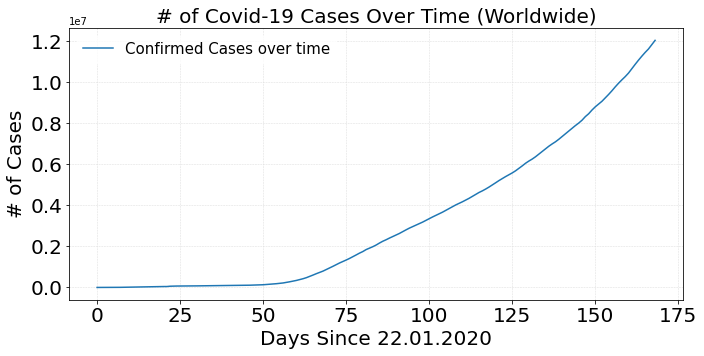

In [14]:
#. Plot days:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]

rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

plt.plot(adjusted_dates, world_cases, label='Confirmed Cases over time')
plt.title('# of Covid-19 Cases Over Time (Worldwide)', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#
leg1  = plt.legend(fontsize=15)
frame = leg1.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

In [15]:
#. create dataframe:
x = future_forcast_dates[:-10] #. future_forcast_dates size is 172, while dates has size of 162
y = world_cases                #. world_cases size is 162

# Calling DataFrame constructor after zipping 
# both lists, with columns specified
x_new = []
for item in x:
    x_new.append(item[:-5])
    
#confirmed_df[confirmed_df['Country/Region']=='China']

df_worldcases = pd.DataFrame(list(zip(x_new, y)), columns =['Date', 'World Cases'])
df_worldcases['World Cases'] = df_worldcases['World Cases'].astype(int)

#. Country:
df_worldcases_all = df_worldcases.copy()

df_worldcases = df_worldcases.set_index('Date')
#print (df_worldcases.dtypes)

df_worldcases.head()

,World Cases
Date,
22/01,555
23/01,654
24/01,941
25/01,1434
26/01,2118


In [16]:
max_world = df_worldcases['World Cases'][len(df_worldcases['World Cases'])-1]
max_world

12041480

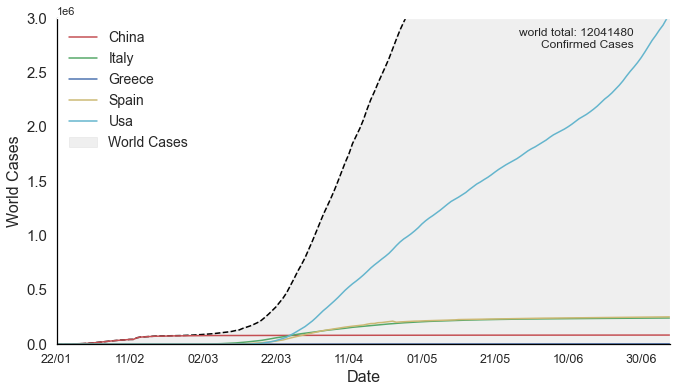

In [17]:
#. Plot dates:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches
import seaborn; seaborn.set()
from matplotlib.pyplot import figure

#. Figure size:
rcParams['figure.figsize'] = 11, 6

#ax = df_worldcases.plot()
ax = df_worldcases.plot.area(color='#dddddd',alpha=0.45)
ax.set_facecolor("white")
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
#ax.tick_params(axis='x', colors='#dddddd')

plt.xlabel('Date', size=16);
plt.ylabel('World Cases', size=16);
plt.xticks(fontsize=12.5, rotation=0)
plt.yticks(size=15)
#plt.title('#of Coronavirus Cases Over Time (Worldwide)', size=15)
#plt.grid(True, color='#dddddd')

# Re-draw the line:
plt.plot(x, y, color='black', linestyle='dashed') #,marker='o', markerfacecolor='blue', markersize=12)

# Draw China, Italy, Greece, Spain and USA cases
ax.plot(x, china_cases, '-r', label='China')
ax.plot(x, italy_cases, '-g', label='Italy')
ax.plot(x, greece_cases, '-b', label='Greece')
ax.plot(x, spain_cases, '-y', label='Spain')
ax.plot(x, usa_cases, '-c', label='Usa')

leg = ax.legend(frameon = 1, fontsize=14)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')

ax.set_ylim([0,0.3e7])
#plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)

#. add text with the total value of the world cases
ax.annotate('world total: '+str(max_world) + '\nConfirmed Cases', xy=(2, 1),  xycoords='data',
            xytext=(0.94, 0.97), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top'
            )

plt.show()

In [18]:
df_worldcases_all['China']  = china_cases
df_worldcases_all['China']  = df_worldcases_all['China'].astype(int)
df_worldcases_all['Italy']  = italy_cases
df_worldcases_all['Italy']  = df_worldcases_all['Italy'].astype(int)
df_worldcases_all['Greece'] = greece_cases
df_worldcases_all['Greece'] = df_worldcases_all['Greece'].astype(int)
df_worldcases_all['Spain']  = spain_cases
df_worldcases_all['Spain']  = df_worldcases_all['Spain'].astype(int)
df_worldcases_all['US']     = usa_cases
df_worldcases_all['US']     = df_worldcases_all['US'].astype(int)
df_worldcases_all['Rest']   = df_worldcases_all['World Cases'] - df_worldcases_all['China'] - df_worldcases_all['Italy'] - df_worldcases_all['Greece'] - df_worldcases_all['Spain'] -  df_worldcases_all['US']

#df_worldcases_all.tail(10)
df_worldcases_all.head(10)

,Date,World Cases,China,Italy,Greece,Spain,US,Rest
0,22/01,555,548,0,0,0,1,6
1,23/01,654,643,0,0,0,1,10
2,24/01,941,920,0,0,0,2,19
3,25/01,1434,1406,0,0,0,2,26
4,26/01,2118,2075,0,0,0,5,38
5,27/01,2927,2877,0,0,0,5,45
6,28/01,5578,5509,0,0,0,5,64
7,29/01,6166,6087,0,0,0,5,74
8,30/01,8234,8141,0,0,0,5,88
9,31/01,9927,9802,2,0,0,7,116


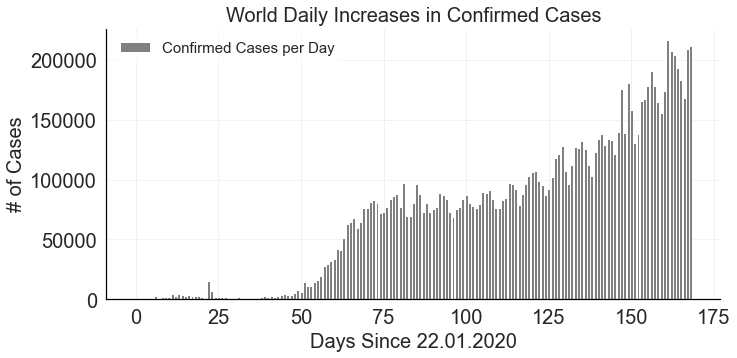

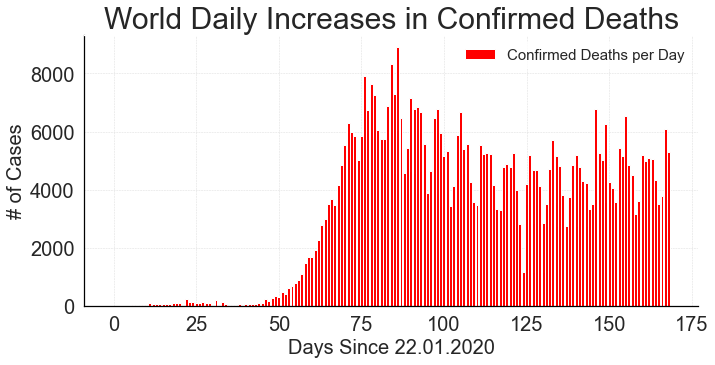

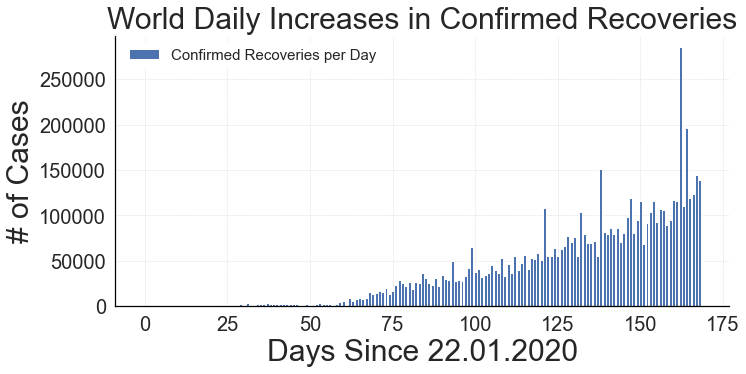

In [19]:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'


#plt.figure(figsize=(11, 5))

# Plot-1
plt.bar(adjusted_dates, world_daily_increase, label='Confirmed Cases per Day', color='grey', width = 0.9)
plt.title('World Daily Increases in Confirmed Cases', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#
leg1  = plt.legend(fontsize=15)
frame = leg1.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

plt.figure(figsize=(11, 5))
plt.bar(adjusted_dates, world_daily_death, label='Confirmed Deaths per Day', color='red', width = 0.9)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#
leg2  = plt.legend(fontsize=15)
frame = leg2.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

plt.figure(figsize=(11, 5))
plt.bar(adjusted_dates, world_daily_recovery, label='Confirmed Recoveries per Day', width = 0.9)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 22.01.2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
leg3  = plt.legend(fontsize=15)
frame = leg3.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
plt.show()

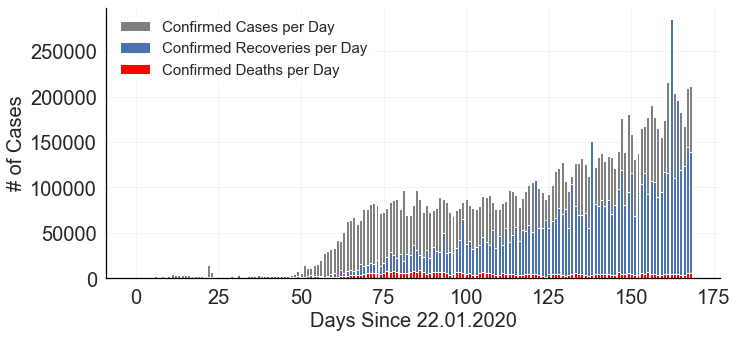

In [20]:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

plt.bar(adjusted_dates, world_daily_increase, label='Confirmed Cases per Day', color='grey', width = 0.9)
plt.bar(adjusted_dates, world_daily_recovery, label='Confirmed Recoveries per Day', width = 0.9)
plt.bar(adjusted_dates, world_daily_death, label='Confirmed Deaths per Day', color='red', width = 0.9)

#plt.title('World Daily Confirmed Cases: PDR', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#
leg1  = plt.legend(fontsize=15)
frame = leg1.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

# Covid-19 in GREECE

## Country Graphs

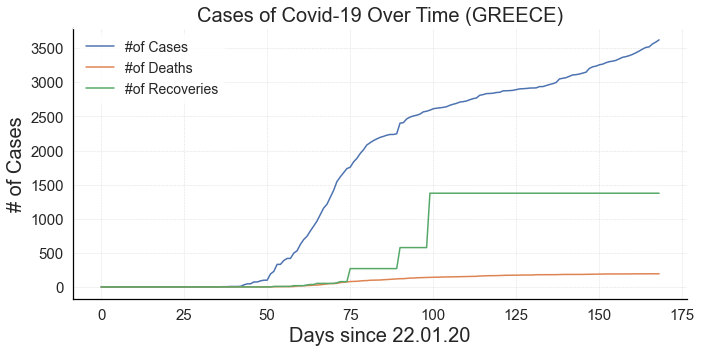

In [21]:
#. Figure size:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

#plt.figure(figsize=(15, 5))
plt.plot(adjusted_dates, greece_cases, label='#of Cases') #x
plt.plot(adjusted_dates, greece_deaths, label='#of Deaths')
plt.plot(adjusted_dates, greece_recoveries, label='#of Recoveries')
plt.title('Cases of Covid-19 Over Time (GREECE)', size=20)
plt.xlabel('Days since 22.01.20', size=20)
plt.ylabel('# of Cases', size=20)

plt.xticks(size=15)
plt.yticks(size=15)

leg = plt.legend(fontsize=14)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
#plt.gca().spines['bottom'].set_position(('zero'))
#plt.gca().xaxis.set_major_locator(plt.NullLocator())

plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)

plt.show()

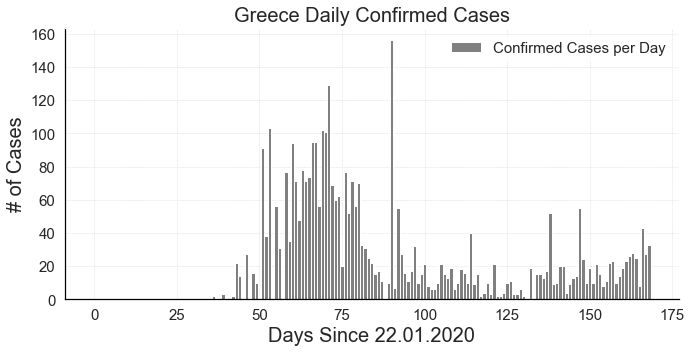

In [22]:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

plt.bar(adjusted_dates, greece_daily_increase, label='Confirmed Cases per Day', color='grey', width = 1.0)

plt.title('Greece Daily Confirmed Cases', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
#
leg  = plt.legend(fontsize=15)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

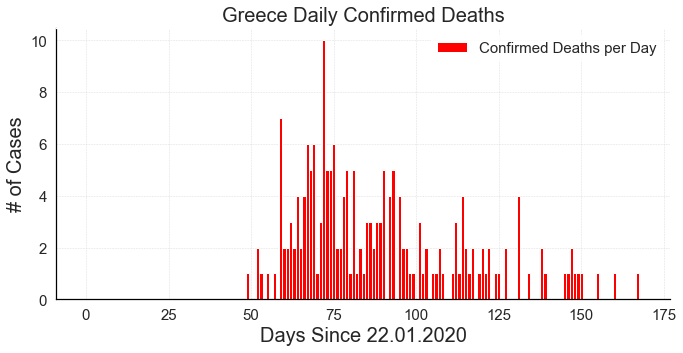

In [23]:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

plt.bar(adjusted_dates, greece_daily_death, label='Confirmed Deaths per Day', color='red', width = 1.0)

plt.title('Greece Daily Confirmed Deaths', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
#
leg  = plt.legend(fontsize=15)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

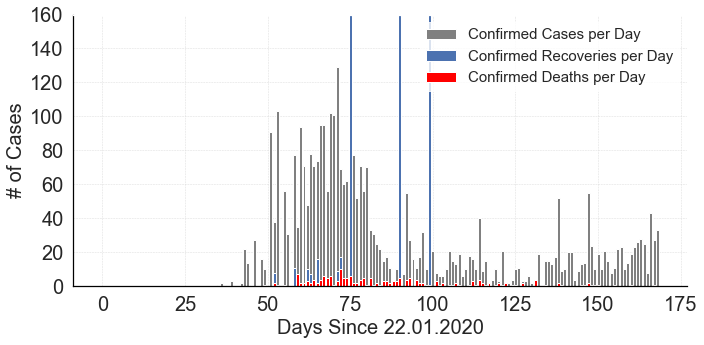

In [24]:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

plt.bar(adjusted_dates, greece_daily_increase, label='Confirmed Cases per Day', color='grey', width = 0.9)
plt.bar(adjusted_dates, greece_daily_recovery, label='Confirmed Recoveries per Day', width = 0.9)
plt.bar(adjusted_dates, greece_daily_death, label='Confirmed Deaths per Day', color='red', width = 0.9)

#plt.title('World Daily Confirmed Cases: PDR', size=20)
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#
leg1  = plt.legend(fontsize=15)
frame = leg1.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.ylim(ymin=0, ymax=160)
#
plt.show()

In [25]:
#lRatio = []
#for i in range(0, len(greece_daily_increase)):
#    if greece_daily_death[i] != 0:
#        #print (i, greece_daily_increase[i]/greece_daily_death[i])
#        lRatio.append( greece_daily_increase[i]/greece_daily_death[i] )

In [26]:
#Cases to mortality ratio:
#plt.figure(figsize=(11, 5))
#plt.title('Greece Daily Mortality Ratio', size=20)
#plt.xlabel('Days Since 1/22/2020', size=20)
#plt.ylabel('# of Cases', size=20)
#plt.xticks(size=15)
#plt.yticks(size=15)
#
#plt.bar(range(0,len(lRatio)), lRatio)
#
#plt.show()

## Greece: Covid-19

In [27]:
lDate             = []
Confirmed_New     = []
Deaths_New        = []
Recoveries_New    = []
Confirmed_Total   = []
Deaths_Total      = []
Recoveries_Total  = []
In_Care_Intensive = [] # In intensive Care (total on that date)
Cum_total_tests   = [] # Cumulative total tests performed

for row in soup.find('table', class_='wikitable').find_all('tr'):
    cells = row.find_all(['th','td'])
    #print(row)
    if len(cells) > 0:
        lDate.append(cells[0].text.rstrip('\n'))
        Confirmed_New.append(cells[1].text.rstrip('\n'))
        Deaths_New.append(cells[2].text.rstrip('\n'))
        Recoveries_New.append(cells[3].text.rstrip('\n'))
        Confirmed_Total.append(cells[4].text.rstrip('\n'))
        Deaths_Total.append(cells[5].text.rstrip('\n'))
        Recoveries_Total.append(cells[6].text.rstrip('\n'))
        In_Care_Intensive.append(cells[7].text.rstrip('\n'))
        Cum_total_tests.append(cells[8].text.rstrip('\n'))

#print(lDate)

In [28]:
# Form a dataframe
dict = {
    'Date'                    : lDate,
    'Confirmed_New_Cases'     : Confirmed_New,
    'Deaths_New_cases'        : Deaths_New,
    'Recoveries_New_cases'    : Recoveries_New,
    'Confirmed_Total_cases'   : Confirmed_Total, 
    'Total_num_of_Deaths'     : Deaths_Total,
    'Recoveries_Total_cases'  : Recoveries_Total,
    'In_Care_Intensive_cases' : In_Care_Intensive, 
    'Cumulative_total_tests'  : Cum_total_tests
}

df_covid19 = pd.DataFrame.from_dict(dict)
df_covid19.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests
0,Date,Confirmed\nNew,Deaths\nNew,Recoveries\nNew,Confirmed\nTotal,Deaths\nTotal,Recoveries\nTotal,In Intensive Care\n(total on that date),Cumulative totaltests performed ^
1,26 February,1,0,0,1,0,0,0,0
2,27 February[177],2,0,0,3,0,0,0,0
3,28 February[178],1,0,0,4,0,0,0,0
4,29 February,3,0,0,7,0,0,0,0


In [29]:
import re

#. Clean data:
#. 1. Clean all the references from the Date column
indx  = 0
count = 0
for element in df_covid19['Date']:
    if re.search('\[.+', element): 
        indx = element.index('[')
        element = element[:indx]
        #print(count, element) 
        df_covid19['Date'][count] = element
    count = count + 1

#. 2. Remove first row: sub-headers
df_covid19 = df_covid19.drop([0])

#. 3. reset_index:
df_covid19 = df_covid19.reset_index(drop=True)

In [30]:
df_covid19.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests
0,26 February,1,0,0,1,0,0,0,0
1,27 February,2,0,0,3,0,0,0,0
2,28 February,1,0,0,4,0,0,0,0
3,29 February,3,0,0,7,0,0,0,0
4,1 March,0,0,0,7,0,0,0,0


In [31]:
#.       ANALYSIS PLAN
#. --------------------------------
#. add 2020 in date column :  DONE
#. Cases by Region table (add region, city, neighborhood, origin: place visited before incident, Hospital)
#. Cases by sex and age table (add sex, age)
#. Critical cases in Emergencies
#. Plots: Cases by date, New cases per day, New deaths per day, New recoveries per day, Active Cases in Greece, NEW CASES PER DAY / TOTAL CASES
#.        AVERAGE AGE: 48.0AVERAGE DEATH AGE: 76.0, GEOGRAPHIC DISTRIBUTION
#. Find one neighborhood of a specific region to demonstrate problems of spreading and monitoring.  + geographic 
#. Response measures
#. case fatality ratio for COVID-19 : comparison with SARS or other known disease

In [32]:
#. 1. add 2020 in date column
import datetime

now = datetime.datetime.now()
print( now.year ) #, now.month, now.day, now.hour, now.minute, now.second

year = '2020' 
df_covid19['Date'] = df_covid19['Date'].astype(str) + ' ' + year

2020


In [33]:
df_covid19.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests
0,26 February 2020,1,0,0,1,0,0,0,0
1,27 February 2020,2,0,0,3,0,0,0,0
2,28 February 2020,1,0,0,4,0,0,0,0
3,29 February 2020,3,0,0,7,0,0,0,0
4,1 March 2020,0,0,0,7,0,0,0,0


In [34]:
#. 2. Cases by Region table (add region, city, neighborhood, origin: place visited before incident, Hospital)
#. and Cases by sex and age table (add sex, age)

# Declare a list that is to be converted into a column 
Region_gr     = ['Attica', 'Central Macedonia','Peloponnese','Thessaly','Western Macedonia','Eastern Macedonia and Thrace',
                 'Western Greece','Central Greece','Crete','Ionian Islands','Epirus','South Aegean','North Aegean' ,
                 'Mount Athos', 'Without permanent residency in Greece', 'Under Investigation'
                ] 

Patient_index = []
for i in range( len(df_covid19['Date']) ):
    Patient_index.append(i+1)

#. Goverements' measures, restictions and plans:
gov_restrictions = []
gov_restrictions_sday = ''
measures         = '24 billions euros (~14% of Greece GDP)'
closed_places    = []


In [35]:
#. Add patient_index column in dataframe  
df_covid19['patient_index'] = Patient_index
df_covid19.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests,patient_index
0,26 February 2020,1,0,0,1,0,0,0,0,1
1,27 February 2020,2,0,0,3,0,0,0,0,2
2,28 February 2020,1,0,0,4,0,0,0,0,3
3,29 February 2020,3,0,0,7,0,0,0,0,4
4,1 March 2020,0,0,0,7,0,0,0,0,5


In [36]:
#. Table 2 : Cases by Region
preshaped_table  = []
table2 = soup.find_all('table', class_='wikitable')
for row in table2:
    cells = row.find_all(['th','td'])
    for elem in cells:
        preshaped_table.append( elem.text.rstrip('\n') )
#print(preshaped_table)

index_rgn = preshaped_table.index("Region") #start
index_tot = preshaped_table.index("Total")  #end
Total     = preshaped_table[index_tot+1]
print('Total_GR_all_regions: ', Total)
#print( preshaped_table[index_rgn:index_tot] )

def split(arr, size):
    arrs = []
    while len(arr) > size:
        pice = arr[:size]
        arrs.append(pice)
        arr   = arr[size:]
    arrs.append(arr)
    return arrs
    
l_by6 = split(preshaped_table[index_rgn:index_tot], 6)
#print( l_by6[0] ) #header

Total_GR_all_regions:  3131


In [37]:
#. Remove headers from the dataframe (index=0)
df_cov19_groupByRegion = pd.DataFrame(l_by6[1:], columns = ['Region', 'Cases', 'Deaths', 'Recov.', 'Active', 'Tests']) 
df_cov19_groupByRegion['Deaths'][13]=0
df_cov19_groupByRegion.head(20)

,Region,Cases,Deaths,Recov.,Active,Tests
0,Attica,1710,81,,,
1,Central Macedonia,213,18,,,
2,Peloponnese,200,1,,,
3,Thessaly,188,2,,,
4,Western Macedonia,180,29,,,
5,Eastern Macedonia and Thrace,357,22,,,
6,Western Greece,86,5,,,
7,Central Greece,85,0,,,
8,Crete,22,1,,,
9,Ionian Islands,15,2,,,


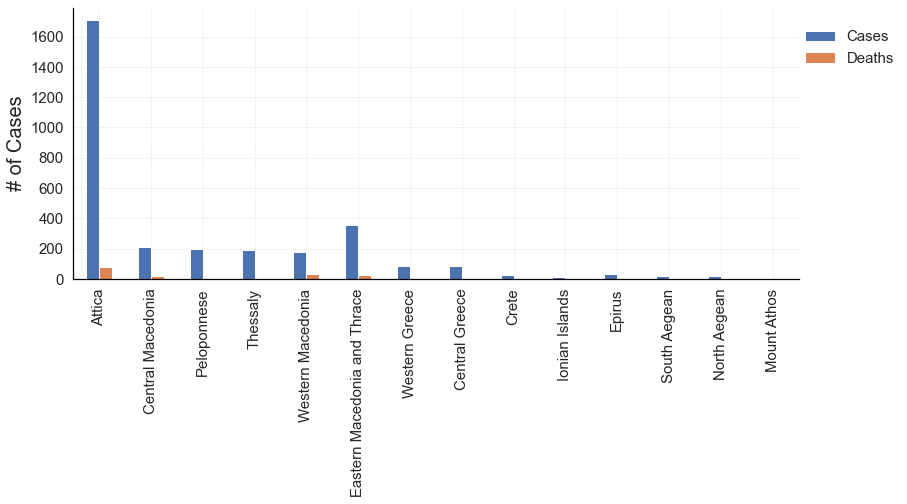

In [38]:
df_cov19_groupByRegion['Cases'] = df_cov19_groupByRegion['Cases'].astype(int)
df_cov19_groupByRegion['Deaths'] = df_cov19_groupByRegion['Deaths'].astype(int)

df_cov19_groupByRegion.dtypes

#. plot:
rcParams['figure.figsize'] = 13, 5
rcParams['axes.facecolor'] = 'white'

df_cov19_groupByRegion.plot(x="Region", y=["Cases","Deaths"], kind="bar")

#plt.title('Greece Daily Confirmed Deaths', size=20)
plt.xlabel('', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15,rotation=90)
plt.yticks(size=15)
#
leg   = plt.legend(fontsize=15, loc='center right', bbox_to_anchor=(1.15, 0.85))
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()


In [40]:
#. Reform the dataframe based on the geojson list indeces
#. ------------------------------------------------------

cov19_groupByRegion_s = df_cov19_groupByRegion.copy()#[:13].copy()
cov19_groupByRegion_s = cov19_groupByRegion_s.drop(['Recov.', 'Active', 'Tests'], axis=1)

#cases_CM = cov19_groupByRegion_s[ cov19_groupByRegion_s['Region']=='Central Macedonia' ][ 'Cases' ][1]
cases_CM = cov19_groupByRegion_s['Cases'].loc[1]
cases_MA = cov19_groupByRegion_s['Cases'].loc[13]
cases_CM_new = cases_CM + cases_MA

cov19_groupByRegion_s['Cases'].loc[1] = cases_CM_new
cov19_groupByRegion_s = cov19_groupByRegion_s[:13]

#change indeces based on geojson indeces.
cov19_groupByRegion_s = cov19_groupByRegion_s.reindex([5,1,3,12,11,7,6,2,0,4,10,9,8])
cov19_groupByRegion_s.reset_index(inplace=True)
cov19_groupByRegion_s = cov19_groupByRegion_s.drop(['index'], axis=1)
cov19_groupByRegion_s['Region'].loc[9] = 'West Macedonia'
#cov19_groupByRegion_s


# cov19_groupByRegion_s
cov19_groupByRegion_dropF = cov19_groupByRegion_s.copy()
cov19_groupByRegion_dropF = cov19_groupByRegion_dropF.drop(columns='Deaths', axis=1)

# Declare a list that is to be converted into a column : cartodb_id
#cartodb_id = ['1', '2', '5', '6', '7', '8', '9', '10', '13', '3', '4', '11', '12'] 
cartodb_id = [1, 2, 5, 6, 7, 8, 9, 10, 13, 3, 4, 11, 12] 
  
# Using 'cartodb_id' as the column name and equating it to the list 
cov19_groupByRegion_dropF['cartodb_id'] = cartodb_id 
cov19_groupByRegion_dropF = cov19_groupByRegion_dropF[['Region', 'cartodb_id', 'Cases']]
cov19_groupByRegion_dropF.head()

#cov19_groupByRegion_s.head()

,Region,cartodb_id,Cases
0,Eastern Macedonia and Thrace,1,357
1,Central Macedonia,2,217
2,Thessaly,5,188
3,North Aegean,6,19
4,South Aegean,7,21


In [522]:
#. Create Map - Folium
#. Greece-healthsites-geojson
gr_geo         = 'http://data.humdata.org/dataset/525dea17-87af-4521-9c0d-ce67994daa38/resource/c7939d32-d451-4e7b-a9c6-ee77cf1b4166/download/greece.geojson'

#. Greece-prefectures-geojson
gr_prefectures = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/greece-prefectures.geojson'

#. Greece-regions-geojson
gr_regions     = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/greece-regions.geojson'

#. Dataframe:
#. Reshape the dataframe to match the geojson file:
cov19_groupByRegion = cov19_groupByRegion_dropF # cov19_groupByRegion_s #

#. Greece location : lat/37.983810, lon/23.727539
latitude_ath    = 37.983810
longitude_ath   = 23.727539
location_gr     = [latitude_ath, longitude_ath]

#. -------------------
#.    Start mapping
#. -------------------

wmap = folium.Map(location_gr, tiles='cartodbpositron', zoom_start=5.8)

#tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
#for tile in tiles:
#    folium.TileLayer(tile).add_to(wmap)

wmap.choropleth(
    geo_data=gr_regions,
    name='choropleth',
    data=cov19_groupByRegion,
    #columns=['Region','Cases'],  
    #key_on='feature.properties.name',  # Issues with the spaces between words
    columns=['cartodb_id','Cases'],
    key_on='feature.properties.cartodb_id',
    fill_color='YlOrRd',#'BuPu', #'YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed Cases'
)

folium.LayerControl().add_to(wmap)

wmap

In [42]:
#. CHECK THE SIZE OF the Data and the geojson files - p1
import geopandas as gpd
states = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/greece-regions.geojson')
states.head()
#states.dtypes

,name,created_at,updated_at,cartodb_id,name_greek,geometry
0,East Macedonia and Thrace,2015-06-21T13:29:48,2015-06-22T10:14:39,1,Ανατολική Μακεδονία και Θράκη,"(POLYGON ((23.622824 41.373806, 23.644021 41.3..."
1,Central Macedonia,2015-06-21T13:29:48,2015-06-22T10:14:46,2,Κεντρική Μακεδονία,"(POLYGON ((21.786855 40.928723, 21.798935 40.9..."
2,Thessaly,2015-06-21T13:29:48,2015-06-22T10:15:05,5,Θεσσαλία,"(POLYGON ((21.294829 39.855151, 21.318197 39.8..."
3,North Aegean,2015-06-21T13:29:48,2015-06-22T10:15:14,6,Βόρειο Αιγαίο,"(POLYGON ((24.968871 39.500729, 24.97582 39.53..."
4,South Aegean,2015-06-21T13:29:48,2015-06-22T10:15:19,7,Νότιο Αιγαίο,"(POLYGON ((26.84261 35.358012, 26.848256 35.37..."


In [43]:
#. CHECK THE SIZE OF the Data and the geojson files - p2

df_cov19_groupByRegion.shape

# For working with geographical data
import geopandas
#!pip install geojson
import geojson

url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/greece-regions.geojson'
data_gjson = pd.read_json(url)
#data_gjson['features'][0]

data_gjson[['type', 'geometry', 'properties']] = data_gjson.features.apply(pd.Series)
data_gjson[['name', 'created_at', 'updated_at','cartodb_id','name_greek']] = data_gjson.properties.apply(pd.Series)
#data_gjson['name']
#data_gjson

In [44]:
#. install libraries and modulus:
#. --------------------------------
#!pip install plotly
#!pip install plotly-geo
#!pip install geopandas==0.3.0
#!pip install pyshp==1.2.10
#!pip install shapely==1.6.3

from urllib.request import urlopen
import plotly.express as px
import plotly.figure_factory as ff

print('Plotly has been imported successfully!')

#. Visualization by country/continent
#fig = px.choropleth(locations = ["Greece"], locationmode = 'country names', color=[1], scope="europe")
#fig.show()

Plotly has been imported successfully!


In [45]:
#. Table 3 : Cases by sex and age

index_class          = preshaped_table.index("Classification") 
index_head_start     = preshaped_table.index("Classification") 
index_head_end       = preshaped_table.index("Cases treated in ICU")+1
index_skip_row_start = preshaped_table.index("Number")                            #start
index_skip_row_end   = preshaped_table.index("All")+1                             #end
index_Sex_start      = preshaped_table.index("Sex")+1                             #start
index_Sex_end        = preshaped_table.index("Age")                               #end
index_Age_start      = preshaped_table.index("Age")+1                             #start
index_Age_end        = preshaped_table.index("Data as of 04.06.2020 15:00 EET.")  #end

l_by4_head = preshaped_table[index_head_start:index_head_end]
print( l_by4_head )

total_sex = preshaped_table[preshaped_table.index("All")+1]
fatal_sex = preshaped_table[preshaped_table.index("All")+3]
icu_sex = preshaped_table[preshaped_table.index("All")+5]

print(50*'-')
print('All grouped by SEX: Total = ', total_sex)
print('All grouped by SEX: Fatal = ', fatal_sex)
print('All grouped by SEX: ICU   = ', icu_sex)


l_by4_sex = split(preshaped_table[index_Sex_start:index_Sex_end] , 7)
#print( l_by4_sex )

l_by4_age = split(preshaped_table[index_Age_start:index_Age_end] , 7)
#print( l_by4_age )

#. Function: Remove pattern from strings in list
#. Remove percentages those with the parenthesis, '('
def filteredlist(myList):
    filtered = []
    for item in myList:
        for i in item:
            if "(" not in i:
                filtered.append(i)
    return filtered
   
# Sex:
filtered_lsex = split(filteredlist(l_by4_sex) , 4)
#print(filtered_lsex)

# Age:
filtered_lage = split(filteredlist(l_by4_age) , 4)
#print(filtered_lage) 

['Classification', 'Cases', 'Fatal cases', 'Cases treated in ICU']
--------------------------------------------------
All grouped by SEX: Total =  2754
All grouped by SEX: Fatal =  180
All grouped by SEX: ICU   =  9


In [46]:
# Form a dataframe
#. Table 3 : Cases by SEX
df_cov19_groupBySex = pd.DataFrame(filtered_lsex, columns = l_by4_head) 
df_cov19_groupBySex.head()

,Classification,Cases,Fatal cases,Cases treated in ICU
0,Male,1518,126,7
1,Female,1236,54,2


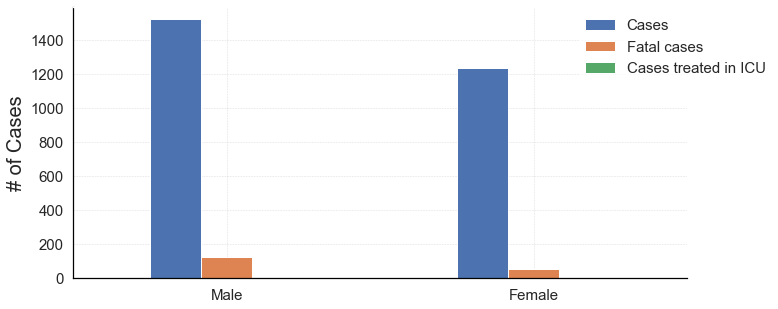

In [47]:
#. Check type:
#df_cov19_groupBySex.dtypes

#. make integers:
df_cov19_groupBySex[['Cases', 'Fatal cases', 'Cases treated in ICU']] = df_cov19_groupBySex[['Cases', 'Fatal cases', 'Cases treated in ICU']].astype(int)

#. Check types again:
df_cov19_groupBySex.dtypes


#. plot:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

df_cov19_groupBySex.plot(x="Classification", y=["Cases","Fatal cases","Cases treated in ICU"], kind="bar")

#plt.title('Greece Daily Confirmed Deaths', size=20)
plt.xlabel('', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15,rotation=0)
plt.yticks(size=15)
#
leg   = plt.legend(fontsize=15, loc='center right', bbox_to_anchor=(1.15, 0.85))
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()


In [48]:
df_cov19_groupBySex['Cases']        = df_cov19_groupBySex['Cases'].astype(int)
df_cov19_groupBySex['Fatal cases']  = df_cov19_groupBySex['Fatal cases'].astype(int)
df_cov19_groupBySex.dtypes

moRatio_male   = ( df_cov19_groupBySex['Fatal cases'][0] / df_cov19_groupBySex['Cases'][0] ) * 100  #. Male
moRatio_female = ( df_cov19_groupBySex['Fatal cases'][1] / df_cov19_groupBySex['Cases'][1] ) * 100  #. Female

print('Mortality ratio: A. male = ', round(moRatio_male,2), '%, B. Female = ',  round(moRatio_female,2), '%')

Mortality ratio: A. male =  8.3 %, B. Female =  4.37 %


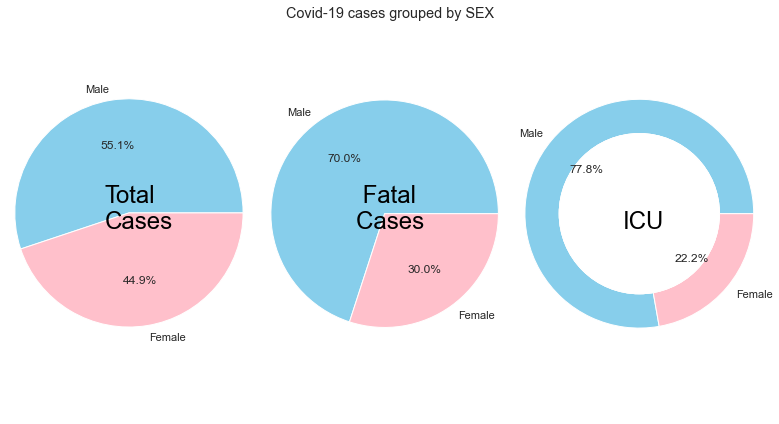

In [658]:
#. Pie chart
labels   = ['Male', 'Female']
Cases    = [df_cov19_groupBySex['Cases'][0], df_cov19_groupBySex['Cases'][1]]
FCases   = [df_cov19_groupBySex['Fatal cases'][0], df_cov19_groupBySex['Fatal cases'][1]]
ICUcases = [df_cov19_groupBySex['Cases treated in ICU'][0], df_cov19_groupBySex['Cases treated in ICU'][1]]

#. colors
colors   = ['skyblue','pink']
explode  = (0.05, 0.05)
 
#. Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Covid-19 cases grouped by SEX')

#. Plot 1
ax1.pie(Cases, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0) #, explode = explode)
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle1)
fig1.text(2, 23, "Total\nCases", transform=ax.transData, color='black', fontsize=24)

#. Plot 2
ax2.pie(FCases, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0) 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(centre_circle2)
fig2.text(36, 23, " Fatal\nCases ", transform=ax.transData, color='black', fontsize=24)  

#. Plot 3
ax3.pie(ICUcases, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0) 
centre_circle3 = plt.Circle((0,0),0.70,fc='white')
fig3 = plt.gcf()
fig3.gca().add_artist(centre_circle3)
fig3.text(72, 23, "ICU", transform=ax.transData, color='black', fontsize=24)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax2.axis('equal')  
ax3.axis('equal')  

plt.tight_layout()

plt.show()

In [52]:
# Form a dataframe
#. Table 3 : Cases by AGE
df_cov19_groupByAge = pd.DataFrame(filtered_lage, columns = l_by4_head) 
df_cov19_groupByAge.head()

,Classification,Cases,Fatal cases,Cases treated in ICU
0,≥65,582,138,5
1,40–64,1154,39,4
2,18–39,859,3,0
3,0–17,159,0,0


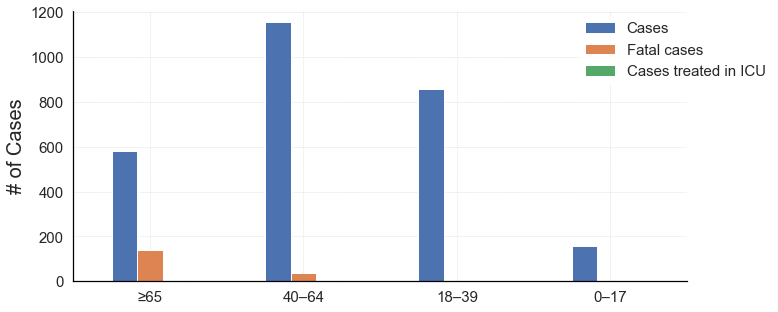

In [53]:
#. make integers:
df_cov19_groupByAge[['Cases', 'Fatal cases', 'Cases treated in ICU']] = df_cov19_groupByAge[['Cases', 'Fatal cases', 'Cases treated in ICU']].astype(int)

#. Check types again:
#df_cov19_groupByAge.dtypes

#. plot:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

df_cov19_groupByAge.plot(x="Classification", y=["Cases","Fatal cases","Cases treated in ICU"], kind="bar")

#plt.title('Greece Daily Confirmed Deaths', size=20)
plt.xlabel('', size=20)
plt.ylabel('# of Cases', size=20)
plt.xticks(size=15,rotation=0)
plt.yticks(size=15)
#
leg   = plt.legend(fontsize=15, loc='center right', bbox_to_anchor=(1.15, 0.85))
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

In [54]:
moRatio_gt65    = ( df_cov19_groupByAge['Fatal cases'][0] / df_cov19_groupByAge['Cases'][0] ) * 100  #. >65
moRatio_btw4064 = ( df_cov19_groupByAge['Fatal cases'][1] / df_cov19_groupByAge['Cases'][1] ) * 100  #. 40-64
moRatio_btw1839 = ( df_cov19_groupByAge['Fatal cases'][2] / df_cov19_groupByAge['Cases'][2] ) * 100  #. 18-39
moRatio_btw017  = ( df_cov19_groupByAge['Fatal cases'][3] / df_cov19_groupByAge['Cases'][3] ) * 100  #. 0-17


print('Mortality ratio per age group \n ---------------------------- \n A. >65   = ', round(moRatio_gt65,2), 
      '% \n B. 40-64 = ',  round(moRatio_btw4064,2), '%', 
      '\n C. 18-39 = ', round(moRatio_btw1839,2), '% \n D. 0-17  = ',  round(moRatio_btw017,2), '%')

Mortality ratio per age group 
 ---------------------------- 
 A. >65   =  23.71 % 
 B. 40-64 =  3.38 % 
 C. 18-39 =  0.35 % 
 D. 0-17  =  0.0 %


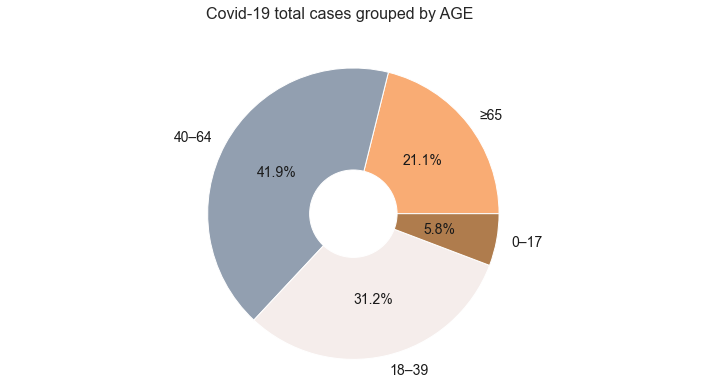

In [525]:
from matplotlib import font_manager as fm

#. Pie chart
labels   = ['≥65', '40–64','18–39','0–17']
y_MR = [moRatio_gt65, moRatio_btw4064, moRatio_btw1839, moRatio_btw017]              # Mortality Ratio
y_cases = df_cov19_groupByAge['Cases']

#. colors
colors   = ['#F9AC74','#929FB0', '#F5EDEB','#AF7C4D']
explode  = (0.05,0.05)
 
#. Subplots
fig, ax1 = plt.subplots()
fig.suptitle('Covid-19 total cases grouped by AGE', fontsize=16)

patches, texts, autotexts = ax1.pie(y_cases, colors = colors, labels=labels, autopct='%1.1f%%', textprops={'color':"k"}, startangle=0) #, explode = explode)

centre_circle1 = plt.Circle((0,0),0.30,fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle1)
ax1.axis('equal')  

proptease = fm.FontProperties()
proptease.set_size('14')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

In [56]:
#. Read the Tracking excel file, and create a new dataframe, clean it and add it to the existing dataframe when needed.


#. UNCOMMENT IF YOU ARE USING THE IBM Watson Studio 
#. -------------------------------------------------
#import types
#from botocore.client import Config
#import ibm_boto3
#
#def __iter__(self): return 0
#
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
#client_YOURCREDS = ibm_boto3.client(
#    service_name='s3',
#    ibm_api_key_id='YOURCREDS',
#    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com'
#)
#
#body = client_YOURCREDS.get_object(Bucket='YOURBUCKETCREDS',Key='covid19_tracking.xlsx')['Body']
## add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
#
#df_track = pd.read_excel(body)
#. -------------------------------------------------

import pandas as pd
trackFile = "covid19_tracking.xlsx"  #Capstone/covid19_tracking.xlsx
df_track  = pd.read_excel(trackFile, index_col=0)
#df_track.head()

In [57]:
#. Clean the df_track dataframe
#. Drop columns and use the get_dummies on the one_hot_decoding!
#. 1. Drop: ['Age','Sex']
#df_track.drop(labels=['Age','Sex'], axis=1,inplace = True)
df_track.head()

,Age,Sex,City_GR,Region_GR,Hospital,Hospital_Recoveries,Hospital_Deaths,City_ABROAD,Region_ABROAD,Relation_between_patients,Date,Intensive Care Units (ICU)
Patient_index,,,,,,,,,,,,
1,38,Female,Thessaloniki,Central Macedonia,AHEPA University Hospital,NaN,NaN,Milan,Italy,Patient 0,2020-02-26,0
2,9/40,Female/Female,Thessaloniki/Athens,Central Macedonia/Attika,AHEPA University Hospital/Attikon University G...,NaN,NaN,Thessaloniki/Milan,Greece/Italy,1/NaN,2020-02-27,0
3,36,Female,Athens,Attika,Attikon University General Hospital,NaN,NaN,NaN,Italy,NaN,2020-02-28,0
4,36/NaN/NaN/NaN,Female/NaN/NaN,Thessaloniki/Athens/Athens,Central Macedonia/Attika/Attika,AHEPA University Hospital/General Hospital Sot...,NaN,NaN,Thessaloniki/NaN/NaN,Greece/NaN/NaN,1/NaN/NaN,2020-02-29,0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01,0


In [58]:
#df_track['Hospital'].head(10)
df1 = pd.DataFrame()
df1['Hospital'] = df_track["Hospital"]

# Drop NaN cells:
df1.dropna(inplace = True) 
df1.head()

,Hospital
Patient_index,
1,AHEPA University Hospital
2,AHEPA University Hospital/Attikon University G...
3,Attikon University General Hospital
4,AHEPA University Hospital/General Hospital Sot...
8,AHEPA University Hospital/General University H...


In [59]:
#. New data frame with split value columns : Split values with '/'
df1_split = df1['Hospital'].str.split("/", n = 1, expand = True) 
df1_split.head(10)

,0,1
Patient_index,,
1,AHEPA University Hospital,None
2,AHEPA University Hospital,Attikon University G...
3,Attikon University General Hospital,None
4,AHEPA University Hospital,General Hospital Sot...
8,AHEPA University Hospital,General University Hospital of Patras
9,AHEPA University Hospital,NaN x 21
10,AHEPA University Hospital,General University Hospital of Patras
11,AHEPA University Hospital,General University Hospital of Patras/ NaN/NaN
13,NaN,General Hospital of Lesbos


In [60]:
df1_split[0].dropna(inplace = True) 
df1_split[0] = df1_split[0].astype(str)
df1_split[0] = df1_split[0][~df1_split[0].isin(['NaN'])]
df1_split[0] = df1_split[0][~df1_split[0].isin(['NaN '])]
df1_split[0] = df1_split[0][~df1_split[0].isin(['NaN x 73'])]
l0 = df1_split[0].value_counts() 
#l0 = df1_split[0].unique() 
print(l0, '\n')

l0_indeces = df1_split[0].value_counts().index
print(l0_indeces[0], ':', l0[0] )


General Hospital of Xanthi             19
AHEPA University Hospital               7
Attikon University General Hospital     1
Name: 0, dtype: int64 

General Hospital of Xanthi : 19


In [61]:
df1_split[1].dropna(inplace = True) 
df1_split[1] = df1_split[1].astype(str)
df1_split[1] = df1_split[1][~df1_split[1].isin(['NaN'])]
df1_split[1] = df1_split[1][~df1_split[1].isin(['NaN x 21'])]

# Rename Hospitals:
attikon_index = df1_split[1].index[df1_split[1] == 'Attikon University G...'].tolist()
sotiria_index = df1_split[1].index[df1_split[1] == 'General Hospital Sot...'].tolist()
df1_split[1][attikon_index] = 'Attikon University General Hospital'
df1_split[1][sotiria_index] = 'General Hospital Sotiria'

# remove 1st empty space:
#df1_split[1] = df1_split[1][:1].str.replace(" ","")
df1_split[1] = df1_split[1].str.lstrip()

# find position of / and remove NaN:
nan_index = df1_split[1].index[df1_split[1] == 'General University Hospital of Patras/ NaN/NaN'].tolist()
df1_split[1][nan_index] = 'General University Hospital of Patras'
    
#hospital = df1_split[1].unique()
#print(hospital, '\n')

l1 = df1_split[1].value_counts() 
#l1 = df1_split[1]#.unique() 
print(l1, "\n")

l1_indeces = df1_split[1].value_counts().index
print(l1_indeces[0], ':', l1[0])

General University Hospital of Patras    5
Alexandroupoli University hospital       1
General Hospital of Ptolemaida           1
General Hospital Sotiria                 1
General Hospital of Lesbos               1
Attikon University General Hospital      1
General Hospital of Kastoria             1
Name: 1, dtype: int64 

General University Hospital of Patras : 5


In [63]:
# . Dataframe concatenation:
df_hosp1 = pd.DataFrame()
df_hosp2 = pd.DataFrame()
df_hosp1['Frequency'] = l0
df_hosp2['Frequency'] = l1

#. df:
frames = [df_hosp1, df_hosp2]
df_hospitals = pd.concat(frames)
df_hospitals = df_hospitals.reset_index()
df_hospitals.rename(columns={"index": "Hospital"},inplace=True)
#df_hospitals.shape

#. find duplicate and its index: 
idx = pd.Index(df_hospitals['Hospital']).duplicated()
indexDD = df_hospitals['Hospital'].index[idx].tolist()
print( df_hospitals['Hospital'].values[idx][0], ', @index:', indexDD[0] )

#. Read value of this entry:
hospital_freq1 = df_hospitals['Frequency'][indexDD[0]] # freq: 1

#. Remove row of this index:
search_hospital = df_hospitals['Hospital'].values[idx][0]
dropIndex = indexDD[0]
df_hospitals = df_hospitals.drop( df_hospitals.index[dropIndex] )
df_hospitals.reset_index(drop=True)

#. add value to the initial entry:
n_index = df_hospitals[df_hospitals['Hospital'].str.contains(search_hospital)].index[0]
df_hospitals['Frequency'][n_index] = df_hospitals['Frequency'][n_index] + hospital_freq1

#. convert all the frequency column elements to int
df_hospitals['Frequency'].astype(int)
df_hospitals.dtypes

Attikon University General Hospital , @index: 8


Hospital     object
Frequency     int64
dtype: object

In [64]:
#. Print Dataframe (reset index): 
df_hospitals.reset_index(drop=True)
df_hospitals = df_hospitals.sort_values(by=['Frequency'], ascending=False)
df_hospitals = df_hospitals.reset_index(drop=True)
df_hospitals

,Hospital,Frequency
0,General Hospital of Xanthi,19
1,AHEPA University Hospital,7
2,General University Hospital of Patras,5
3,Attikon University General Hospital,2
4,Alexandroupoli University hospital,1
5,General Hospital of Ptolemaida,1
6,General Hospital Sotiria,1
7,General Hospital of Lesbos,1
8,General Hospital of Kastoria,1


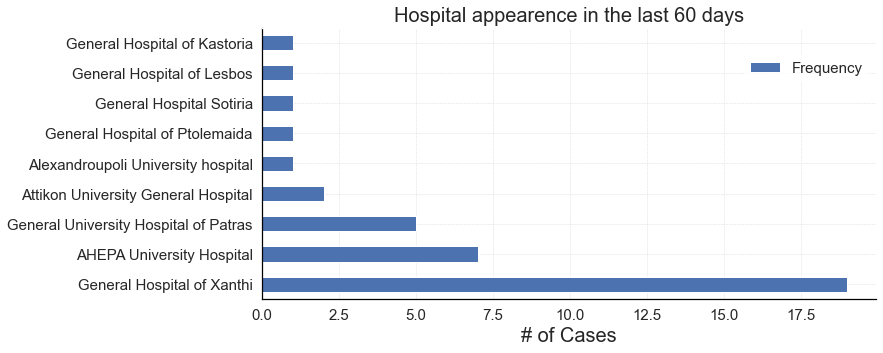

In [65]:
#. Draw bar plot:
#. make integers:
df_hospitals['Frequency'] = df_hospitals['Frequency'].astype(int)

#. Check types again:
#df_cov19_groupByAge.dtypes

#. plot:
rcParams['figure.figsize'] = 11, 5
rcParams['axes.facecolor'] = 'white'

df_hospitals.plot(x="Hospital", y=["Frequency"], kind="barh")

#plt.title('Greece Daily Confirmed Deaths', size=20)
plt.ylabel('', size=20)
plt.xlabel('# of Cases', size=20)
plt.xticks(size=15,rotation=0)
plt.yticks(size=15)
plt.title("Hospital appearence in the last 60 days", fontsize=20)
#
leg   = plt.legend(fontsize=15, loc='center right', bbox_to_anchor=(1.0, 0.85))
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.grid(color='#dddddd', linestyle='--', linewidth=0.5)
#
plt.show()

In [66]:
# Draw Plots : 
#!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams

#print('matplotlib: {}'.format(matplotlib.__version__))

# Modeling
## Predictions for confirmed coronavirus cases worldwide

In [68]:
import random
import math
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [69]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(
    days_since_1_22,#[50:], 
    #world_cases,#[50:], 
    #adjusted_dates, 
    greece_cases,
    test_size=0.16, 
    shuffle=False
)


In [70]:
#. Model for predicting number of confirmed cases. 
#. I am using support vector machine, bayesian ridge , and linear regression in this example.

# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [71]:
# svm_search.best_params_

In [72]:
# svm_confirmed = svm_search.best_estimator_

svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)#.ravel())
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 2957.4694248098635
MSE: 9432042.813044718


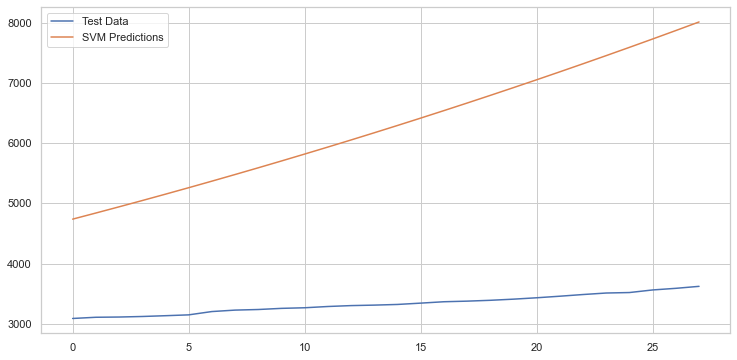

In [660]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [74]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [75]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2549.8876959974264
MSE: 10587791.615003387


In [76]:
print(linear_model.coef_)

[-1.15414659e+02  4.53805787e+01 -3.46059645e+00  8.62305907e-02
 -7.49376539e-04  2.15807005e-06]


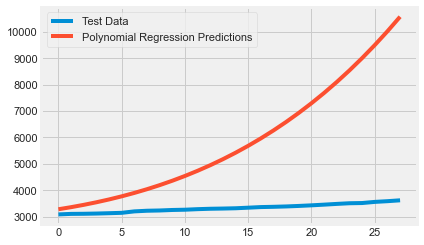

In [77]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [78]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)#.ravel())

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.4s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [79]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': False,
 'lambda_2': 1e-05,
 'lambda_1': 0.001,
 'alpha_2': 0.001,
 'alpha_1': 0.001}

In [80]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 2319.202983243998
MSE: 7039870.411149336


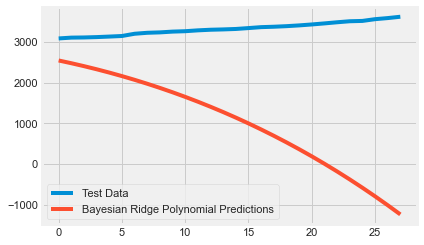

In [81]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

### Plot predictions

In [82]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

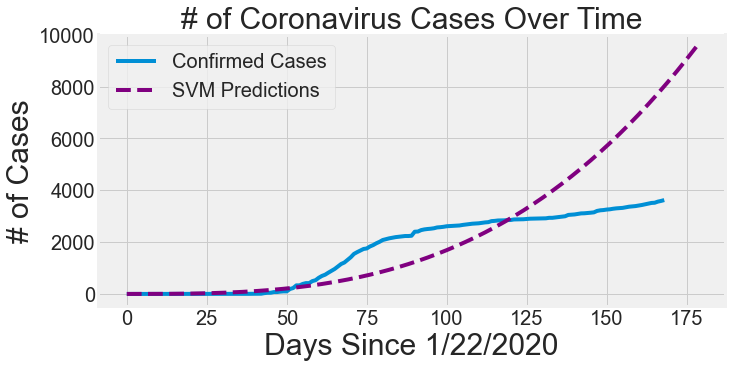

In [83]:
plot_predictions(adjusted_dates, greece_cases, svm_pred, 'SVM Predictions', 'purple')

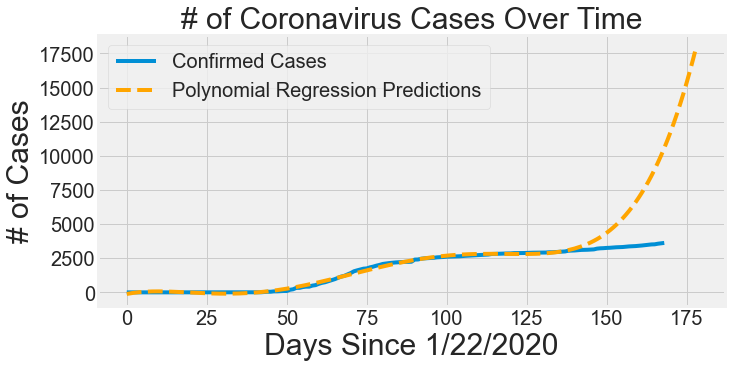

In [84]:
plot_predictions(adjusted_dates, greece_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

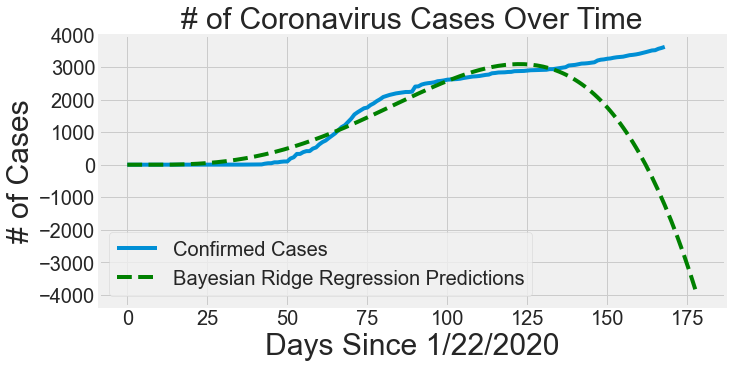

In [85]:
plot_predictions(adjusted_dates, greece_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [86]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases in Greece': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases in Greece
0,09/07/2020,8159.0
1,10/07/2020,8305.0
2,11/07/2020,8452.0
3,12/07/2020,8602.0
4,13/07/2020,8753.0
5,14/07/2020,8905.0
6,15/07/2020,9060.0
7,16/07/2020,9216.0
8,17/07/2020,9374.0
9,18/07/2020,9534.0


In [87]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases in Greece': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases in Greece
0,09/07/2020,11153.0
1,10/07/2020,11767.0
2,11/07/2020,12414.0
3,12/07/2020,13096.0
4,13/07/2020,13813.0
5,14/07/2020,14568.0
6,15/07/2020,15360.0
7,16/07/2020,16192.0
8,17/07/2020,17065.0
9,18/07/2020,17980.0


In [88]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases in Greece': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases in Greece
0,09/07/2020,-1479.0
1,10/07/2020,-1722.0
2,11/07/2020,-1973.0
3,12/07/2020,-2232.0
4,13/07/2020,-2500.0
5,14/07/2020,-2777.0
6,15/07/2020,-3062.0
7,16/07/2020,-3356.0
8,17/07/2020,-3659.0
9,18/07/2020,-3972.0


## Active cases


In [171]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing

#. fbprophet: 
#. Implements a procedure for forecasting time series data based on an additive model 
#. where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
#!pip install fbprophet
from fbprophet import Prophet
print('fbprophet has been imported.')

from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

#. pyramid:
#. Pyramid is a no-nonsense statistical Python library with a 
#. solitary objective: bring R's auto.arima functionality to Python.
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
#. or
!pip install pmdarima
from pmdarima.arima import auto_arima
print('pyramid.arima has been imported.')
print('Done.')


std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

fbprophet has been imported.
     |████████████████████████████████| 604kB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 8.4MB 11.1MB/s eta 0:00:01████▊             | 4.9MB 11.1MB/s eta 0:00:01     |██████████████████████▌         | 5.9MB 11.1MB/s eta 0:00:01
     |████████████████████████████████| 15.3MB 21.2MB/s eta 0:00:01
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.5.1 which is incompatible.
  Found existing installation: numpy 1.17.2
    Uninstalling numpy-1.17.2:
      Successfully uninstalled numpy-1.17.2
  Found existing installation: statsmodels 0.10.1
    Uninstalling statsmodels-0.10.1:
      Successfully uninstalled statsmodels-0.10.1
pyramid.arima has been imported.
Done.


In [174]:
#. Basic dataframes: df_covid19 and df_cov19_groupByRegion

print("Size/Shape of the dataset: ",df_covid19.shape)
print("Checking for null values:\n",df_covid19.isnull().sum())
print("Checking Data-type of each column:\n",df_covid19.dtypes)

Size/Shape of the dataset:  (131, 10)
Checking for null values:
 Date                       0
Confirmed_New_Cases        0
Deaths_New_cases           0
Recoveries_New_cases       0
Confirmed_Total_cases      0
Total_num_of_Deaths        0
Recoveries_Total_cases     0
In_Care_Intensive_cases    0
Cumulative_total_tests     0
patient_index              0
dtype: int64
Checking Data-type of each column:
 Date                       object
Confirmed_New_Cases        object
Deaths_New_cases           object
Recoveries_New_cases       object
Confirmed_Total_cases      object
Total_num_of_Deaths        object
Recoveries_Total_cases     object
In_Care_Intensive_cases    object
Cumulative_total_tests     object
patient_index               int64
dtype: object


### Greece: Active Cases

In [89]:
#. Greece:
df_covid19_exp = df_covid19.copy()
print( 'dtypes[Recoveries_New_cases]: ',df_covid19_exp['Recoveries_New_cases'].dtypes, '\n' )

#. Check empty cells: 0, 0
emptyR = df_covid19_exp['Recoveries_New_cases'].isnull().sum()
emptyD = df_covid19_exp['Deaths_New_cases'].isnull().sum()
#print('empty R:', emptyR, 'empty D:',emptyD)

#. Remove '-' from cell values:
df_covid19_exp['Recoveries_New_cases'][df_covid19_exp['Recoveries_New_cases'] == '–'] = 0  
df_covid19_exp['Recoveries_New_cases'][df_covid19_exp['Recoveries_New_cases'] == '']  = 0 

#. Remove last row:
df_covid19_exp = df_covid19_exp[:-1]

#convert to int by removing the symbol: - 

listitem1 = []
for item in df_covid19_exp['Recoveries_New_cases']:
    if item =='—':
        listitem1.append(0)
    else:
        listitem1.append(item)

df_covid19_exp['Recoveries_New_cases'] = listitem1

listitem2 = []
for item in df_covid19_exp['Deaths_New_cases']:
    if item =='—':
        listitem2.append(0)
    else:
        listitem2.append(item)

df_covid19_exp['Deaths_New_cases']     = listitem2

df_covid19_exp['Recoveries_New_cases'] = df_covid19_exp['Recoveries_New_cases'].astype(int)
df_covid19_exp['Deaths_New_cases']     = df_covid19_exp['Deaths_New_cases'].astype(int)

df_covid19_exp.dtypes

dtypes[Recoveries_New_cases]:  object 



Date                       object
Confirmed_New_Cases        object
Deaths_New_cases            int64
Recoveries_New_cases        int64
Confirmed_Total_cases      object
Total_num_of_Deaths        object
Recoveries_Total_cases     object
In_Care_Intensive_cases    object
Cumulative_total_tests     object
patient_index               int64
dtype: object

In [261]:
#. Converting "Observation Date" into Datetime format
df_covid19_exp["ObservationDate"] = pd.to_datetime(df_covid19_exp["Date"])

#. remove '-' from confirmed cases:
confirmed = []
for item in df_covid19_exp['Confirmed_New_Cases']:
    if item =='—':
        confirmed.append(0)
    else:
        confirmed.append(item)

df_covid19_exp['Confirmed_New_Cases'] = confirmed
df_covid19_exp['Confirmed_New_Cases'] = df_covid19_exp['Confirmed_New_Cases'].astype(int)

df_covid19_exp["Active Cases"] = df_covid19_exp["Confirmed_New_Cases"] - df_covid19_exp["Recoveries_New_cases"] - df_covid19_exp["Deaths_New_cases"]
df_covid19_exp["Closed Cases"] = df_covid19_exp["Recoveries_New_cases"] + df_covid19_exp["Deaths_New_cases"]

#df_covid19_exp.dtypes
df_covid19_exp.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests,patient_index,ObservationDate,Active Cases,Closed Cases
0,26 February 2020,1,0,0,1,0,0,0,0,1,2020-02-26,1,0
1,27 February 2020,2,0,0,3,0,0,0,0,2,2020-02-27,2,0
2,28 February 2020,1,0,0,4,0,0,0,0,3,2020-02-28,1,0
3,29 February 2020,3,0,0,7,0,0,0,0,4,2020-02-29,3,0
4,1 March 2020,0,0,0,7,0,0,0,0,5,2020-03-01,0,0


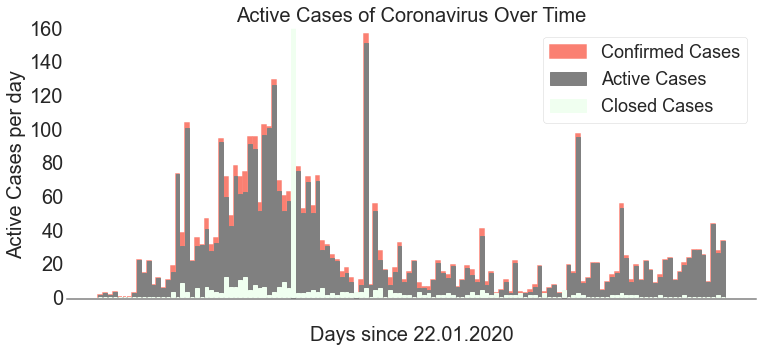

In [268]:
plt.figure(figsize=(11, 5))
rcParams['axes.facecolor'] = 'white'
rcParams['axes.linewidth'] = 1.5

dates   = df_covid19_exp["Date"]
actives = df_covid19_exp["Active Cases"]
ClosedCases = df_covid19_exp["Closed Cases"]

#. bar:
plt.bar(df_covid19_exp["Date"], df_covid19_exp["Confirmed_New_Cases"],label='Confirmed Cases per Day', color='salmon',linewidth=1.5, edgecolor='salmon')
plt.bar(df_covid19_exp["Date"], actives, color='grey',linewidth=1.0, label='Active Cases per Day', edgecolor='grey')
plt.bar(df_covid19_exp["Date"], ClosedCases, color='honeydew',linewidth=1.0, label='Closed Cases per Day', edgecolor='honeydew')

plt.title('Active Cases of Coronavirus Over Time', size=20 )
plt.legend(['Confirmed Cases', 'Active Cases', 'Closed Cases'], prop={'size': 18})
plt.xlabel('Days since 22.01.2020', size=20)
plt.ylabel('Active Cases per day', size=20)
plt.xticks(size=20)
plt.xticks(color='w') #Hide Axis Label / Text in Matplotlib
plt.yticks(size=20)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.ylim(ymax = 160, ymin = -1.5)

plt.show()


### Growth Factor

Growth factor is the factor by which a quantity multiplies itself over time. The formula used is:

Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.

A growth factor above 1 indicates an increase correspoding cases.

A growth factor above 1 but trending downward is a positive sign, whereas a growth factor constantly above 1 is the sign of exponential growth.

A growth factor constant at 1 indicates there is no change in any kind of cases.

In [279]:
#print("Average growth factor of number of Confirmed Cases: ",(df_covid19_exp["Confirmed_New_Cases"]/df_covid19_exp["Confirmed_New_Cases"].shift()).mean())
print("Median growth factor of number of Confirmed Cases : ",(df_covid19_exp["Confirmed_New_Cases"]/df_covid19_exp["Confirmed_New_Cases"].shift()).median())
#print("Average growth factor of number of Recovered Cases: ",(df_covid19_exp["Recoveries_New_cases"]/df_covid19_exp["Recoveries_New_cases"].shift()).mean())
print("Median growth factor of number of Recovered Cases : ",(df_covid19_exp["Recoveries_New_cases"]/df_covid19_exp["Recoveries_New_cases"].shift()).median())
#print("Average growth factor of number of Death Cases    : ",(df_covid19_exp["Deaths_New_cases"]/df_covid19_exp["Deaths_New_cases"].shift()).mean())
print("Median growth factor of number of Death Cases     : ",(df_covid19_exp["Deaths_New_cases"]/df_covid19_exp["Deaths_New_cases"].shift()).median())


Median growth factor of number of Confirmed Cases :  1.0422535211267605
Median growth factor of number of Recovered Cases :  1.3333333333333333
Median growth factor of number of Death Cases     :  1.0


In [287]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Confirmed_New_Cases"]/df_covid19_exp["Confirmed_New_Cases"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Closed Cases"]/df_covid19_exp["Closed Cases"].shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor")
fig.show()

In [292]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Confirmed_New_Cases"].fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Recoveries_New_cases"].fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Deaths_New_cases"].fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in Greece",
                 xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

## Prediction using Machine Learning Models

In [306]:
#df_covid19_exp.index
df_covid19_exp["Days Since"] = df_covid19_exp.index-df_covid19_exp.index[0]
#df_covid19_exp["Days since 22.01.2020"] = df_covid19_exp["Days since 22.01.2020"].dt.days

#. Remove columns:
#df_covid19_exp = df_covid19_exp.drop('Days since 22.01.2020', axis=1)
    
df_covid19_exp.head()


,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests,patient_index,ObservationDate,Active Cases,Closed Cases,Days Since,Days since 22.01.2020
0,26 February 2020,1,0,0,1,0,0,0,0,1,2020-02-26,1,0,0,0
1,27 February 2020,2,0,0,3,0,0,0,0,2,2020-02-27,2,0,1,1
2,28 February 2020,1,0,0,4,0,0,0,0,3,2020-02-28,1,0,2,2
3,29 February 2020,3,0,0,7,0,0,0,0,4,2020-02-29,3,0,3,3
4,1 March 2020,0,0,0,7,0,0,0,0,5,2020-03-01,0,0,4,4


In [307]:
train_ml=df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid_ml=df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]
model_scores=[]


In [312]:
#. remove '-' from confirmed cases:
confirmed_tot = []
for item in df_covid19_exp['Confirmed_Total_cases']:
    if item =='—':
        confirmed_tot.append(0)
    else:
        confirmed_tot.append(item)

df_covid19_exp['Confirmed_Total_cases'] = confirmed_tot
df_covid19_exp['Confirmed_Total_cases'] = df_covid19_exp['Confirmed_Total_cases'].astype(int)

#df_covid19_exp.dtypes
df_covid19_exp.head()

,Date,Confirmed_New_Cases,Deaths_New_cases,Recoveries_New_cases,Confirmed_Total_cases,Total_num_of_Deaths,Recoveries_Total_cases,In_Care_Intensive_cases,Cumulative_total_tests,patient_index,ObservationDate,Active Cases,Closed Cases,Days Since,Days since 22.01.2020
0,26 February 2020,1,0,0,1,0,0,0,0,1,2020-02-26,1,0,0,0
1,27 February 2020,2,0,0,3,0,0,0,0,2,2020-02-27,2,0,1,1
2,28 February 2020,1,0,0,4,0,0,0,0,3,2020-02-28,1,0,2,2
3,29 February 2020,3,0,0,7,0,0,0,0,4,2020-02-29,3,0,3,3
4,1 March 2020,0,0,0,7,0,0,0,0,5,2020-03-01,0,0,4,4


### 1. Linear Regression for Prediction of Confirmed Cases

In [313]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days since 22.01.2020"]).reshape(-1,1),np.array(train_ml["Confirmed_Total_cases"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days since 22.01.2020"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed_Total_cases"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed_Total_cases"],prediction_valid_linreg)))


Root Mean Square Error for Linear Regression:  475.2469699722008


In [314]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(df_covid19_exp["Days since 22.01.2020"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line")
             )
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases"
                 )
fig.show()

<Figure size 792x432 with 0 Axes>

**The Linear Regression Model is absolutely falling apart. As it is clearly visible that the trend of Confirmed Cases in absolutely not Linear.** \

### 2. Polynomial Regression for Prediction of Confirmed Cases

In [315]:
#. create poly line:
train_ml=df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid_ml=df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]

poly = PolynomialFeatures(degree = 2) 

train_poly=poly.fit_transform(np.array(train_ml["Days since 22.01.2020"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days since 22.01.2020"]).reshape(-1,1))
y=train_ml["Confirmed_Total_cases"]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed_Total_cases"],prediction_poly))
model_scores.append(rmse_poly)

print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  280.2179900842015


In [316]:
#. Plot:

comp_data=poly.fit_transform(np.array(df_covid19_exp["Days since 22.01.2020"]).reshape(-1,1))

plt.figure(figsize=(11,6))

predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit")
             )
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases"
                 )
fig.show()

<Figure size 792x432 with 0 Axes>

### 3. Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [509]:
train_ml=df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid_ml=df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]

In [510]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [511]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days since 22.01.2020"]).reshape(-1,1),np.array(train_ml["Confirmed_Total_cases"]).reshape(-1,1))

SVR(C=1, degree=5, epsilon=0.01, kernel='poly')

In [512]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days since 22.01.2020"]).reshape(-1,1))

In [513]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed_Total_cases"],prediction_valid_svm)))

print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed_Total_cases"],prediction_valid_svm)))


Root Mean Square Error for Support Vectore Machine:  875.345982281892


In [518]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(df_covid19_exp["Days since 22.01.2020"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=df_covid19_exp["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=df_covid19_exp.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel"))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

<Figure size 792x432 with 0 Axes>

#### split data

In [425]:
#. separator at 30% of the data size:
len_x = int( len(df_covid19_exp["Confirmed_Total_cases"]) * 0.3 )
#len_x

#. split data:
X = df_covid19_exp["Confirmed_Total_cases"][:l-len_x].to_numpy()
Y = df_covid19_exp["Confirmed_Total_cases"][l-len_x:].to_numpy()
#X, Y

In [422]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Time Series Forecasting

### 1. Holt's Linear Model

In [495]:
model_train = df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid       = df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]
y_pred      = valid.copy()

In [496]:
holt = Holt(np.asarray(model_train["Confirmed_Total_cases"])).fit(smoothing_level=0.1, smoothing_slope=1.5,optimized=False)
#holt

In [497]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["Holt"])))

print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["Holt"])))


Root Mean Square Error Holt's Linear Model:  30.898639741478952


In [498]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed_Total_cases"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

### 2. AR Model (using AUTO ARIMA)

In [461]:
model_train = df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid       = df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]
y_pred      = valid.copy()

model_ar= auto_arima(model_train["Confirmed_Total_cases"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed_Total_cases"])


Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1732.336, BIC=1737.944, Time=0.191 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1706.012, BIC=1714.424, Time=0.032 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1696.792, BIC=1708.008, Time=0.031 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=1694.432, BIC=1708.453, Time=0.035 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=1694.360, BIC=1711.184, Time=0.116 seconds
Total fit time: 0.464 seconds


ARIMA(order=(4, 1, 0), suppress_warnings=True)

In [462]:
prediction_ar = model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [464]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["AR Model Prediction"])))

print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["AR Model Prediction"])))


Root Mean Square Error for AR Model:  23.731646807112238


In [465]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed_Total_cases"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

### 3. MA Model (using AUTO ARIMA)

In [482]:
model_train = df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid       = df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]
y_pred      = valid.copy()

In [483]:
model_ma= auto_arima(model_train["Confirmed_Total_cases"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=5,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed_Total_cases"])


Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1732.336, BIC=1737.944, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1687.267, BIC=1695.679, Time=0.147 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1689.265, BIC=1700.481, Time=0.168 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=1691.067, BIC=1705.087, Time=0.184 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=1693.004, BIC=1709.828, Time=0.234 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=1694.885, BIC=1714.513, Time=0.257 seconds
Total fit time: 1.013 seconds


ARIMA(order=(0, 1, 1), suppress_warnings=True)

In [484]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [485]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed_Total_cases"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed_Total_cases"],prediction_ma)))

Root Mean Square Error for MA Model:  34.9619410547657


In [486]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed_Total_cases"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

### 4. SARIMA Model (using AUTO ARIMA)

In [500]:
model_train = df_covid19_exp.iloc[:int(df_covid19_exp.shape[0]*0.95)]
valid       = df_covid19_exp.iloc[int(df_covid19_exp.shape[0]*0.95):]
y_pred      = valid.copy()

model_sarima= auto_arima(model_train["Confirmed_Total_cases"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=3,max_q=3,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed_Total_cases"])

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=1736.333, BIC=1747.549, Time=0.052 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=1732.336, BIC=1737.944, Time=0.012 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=1707.998, BIC=1719.214, Time=0.101 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=1689.180, BIC=1700.396, Time=0.170 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=1731.491, BIC=1734.295, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,7) [intercept=True]; AIC=1687.267, BIC=1695.679, Time=0.092 seconds
Fit ARIMA(0,1,1)x(1,0,0,7) [intercept=True]; AIC=1689.178, BIC=1700.394, Time=0.171 seconds
Fit ARIMA(0,1,1)x(1,0,1,7) [intercept=True]; AIC=1691.269, BIC=1705.289, Time=0.334 seconds
Near non-invertible roots for order (0, 1, 1)(1, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,0,0,7) [intercept=True]; AIC=1689.265, BIC

ARIMA(order=(0, 1, 1), seasonal_order=(0, 0, 0, 7), suppress_warnings=True)

In [501]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [502]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["SARIMA Model Prediction"])))

print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed_Total_cases"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  34.9619410547657


In [503]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed_Total_cases"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed_Total_cases"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

### Summarization of Forecasts using different Models

In [520]:
model_names = ["Linear Regression", 
               "Polynomial Regression",
               "Support Vector Machine Regressor",
               "Holt's Linear",
               "Auto Regressive Model (AR)", 
               "Moving Average Model (MA)",
               "SARIMA Model"]
model_scores = [475.25, 280.22, 875.35, 30.89, 23.73, 34.96, 34.96]

model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name", "Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
4,Auto Regressive Model (AR),23.73
3,Holt's Linear,30.89
5,Moving Average Model (MA),34.96
6,SARIMA Model,34.96
1,Polynomial Regression,280.22
0,Linear Regression,475.25
2,Support Vector Machine Regressor,875.35


### Greece: Mortality and Recovery Rates

In [277]:
print("Average increase in number of Confirmed Cases every day : ",np.round( df_covid19_exp["Confirmed_New_Cases"].fillna(0).mean() ))
print("Average increase in number of Recovered Cases every day : ",np.round( df_covid19_exp["Recoveries_New_cases"].fillna(0).mean() ))
print("Average increase in number of Death Cases every day     : ",np.round( df_covid19_exp["Deaths_New_cases"].fillna(0).mean() ))


Average increase in number of Confirmed Cases every day :  28.0
Average increase in number of Recovered Cases every day :  2.0
Average increase in number of Death Cases every day     :  1.0


In [90]:
#. Greece:
#df_covid19_exp['mortality_rate'] = df_covid19_exp.apply(lambda row: row.Recoveries_New_cases / row.Deaths_New_cases, axis=1)

#greece_cases, greece_recoveries, greece_deaths

mortality_rate_gr = []
recovery_rate_gr  = []
for i in range(len(greece_recoveries)):
    if greece_cases[i] == 0:
        #continue
        mortality_rate_gr.append(0)
        recovery_rate_gr.append(0)
    else:
        mortality_rate_gr.append(greece_deaths[i] / greece_cases[i] )
        recovery_rate_gr.append(greece_recoveries[i] / greece_cases[i] )

#print(mortality_rate_gr)
#print(recovery_rate_gr)


0.03448603477213197


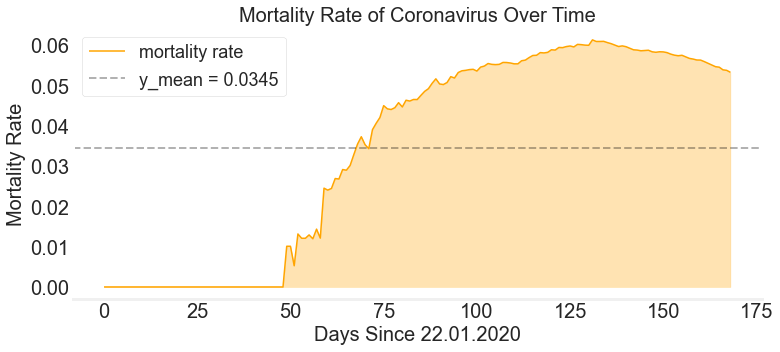

In [163]:
#. Greece:
mean_mortality_rate = np.mean(mortality_rate_gr)
print(mean_mortality_rate)

plt.figure(figsize=(11, 5))
rcParams['axes.facecolor'] = 'white'

plt.plot(adjusted_dates, mortality_rate_gr, color='orange',linewidth=1.5)
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black', linewidth=2, alpha=0.3)
plt.fill_between(adjusted_dates, mortality_rate_gr, color='orange', alpha=0.3)

plt.title('Mortality Rate of Coronavirus Over Time', size=20 )
plt.legend(['mortality rate', 'y_mean = '+str(round(mean_mortality_rate,4)) ], prop={'size': 18})
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('Mortality Rate', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(color='white', linestyle='--', linewidth=0.5)
#plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.show()

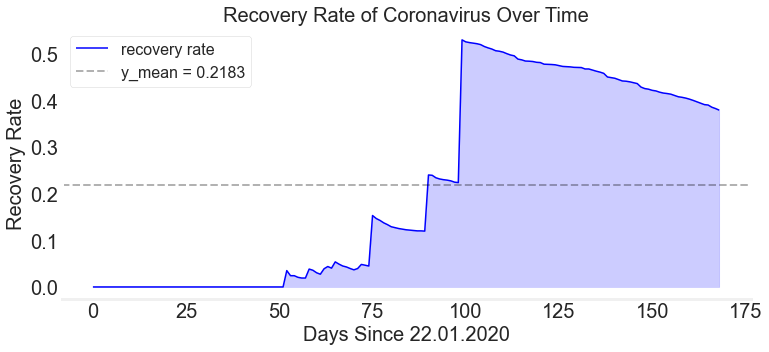

In [164]:
mean_recovery_rate = np.mean(recovery_rate_gr)

plt.figure(figsize=(11, 5))
rcParams['axes.facecolor'] = 'white'

plt.plot(adjusted_dates, recovery_rate_gr, color='blue',linewidth=1.5)
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black', linewidth=2, alpha=0.3)
plt.fill_between(adjusted_dates, recovery_rate_gr, color='blue', alpha=0.2)

plt.title('Recovery Rate of Coronavirus Over Time', size=20)
plt.legend(['recovery rate', 'y_mean = '+str(round(mean_recovery_rate,4)) ], prop={'size': 16})
plt.xlabel('Days Since 22.01.2020', size=20)
plt.ylabel('Recovery Rate', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(color='white', linestyle='--', linewidth=0.5)
#plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.show()

In [96]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [97]:
country_confirmed_cases = []
country_death_cases     = [] 
country_active_cases    = []
country_recovery_cases  = []
country_mortality_rate  = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [521]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

#country_df[country_df['Country Name']=='Greece'].style.background_gradient(cmap='Greens') # index: 92
country_df[90:101].style.background_gradient(cmap='Blues') #Oranges')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
90,Bosnia and Herzegovina,3935,178,2338,1419,0.0452351
91,Central African Republic,3429,45,699,2685,0.0131234
92,Greece,3376,191,1374,1811,0.0565758
93,Thailand,3162,58,3053,51,0.0183428
94,Costa Rica,3130,15,1366,1749,0.00479233
95,Somalia,2894,90,887,1917,0.0310988
96,Croatia,2691,107,2152,432,0.0397622
97,Albania,2402,55,1384,963,0.0228976
98,Cuba,2332,86,2201,45,0.0368782
99,Maldives,2324,8,1911,405,0.00344234


## Use Foursquare location data for Athens, GR


In [589]:
from geopy.geocoders import Nominatim 

#Get coordinates of Athens 
#address = 'Rimini Street 1, 12462, GR' #. Attikon Hospital
#address = 'Athens, GR' # Omonoia
address = '15 Dionysiou Areopagitou Street, 11742, GR' # Acropolis

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ATHENS are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of ATHENS are 37.9684941, 23.728487.


In [667]:
CLIENT_ID = 'add-your-client-id' # your Foursquare ID
CLIENT_SECRET = 'add-your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: add-your-client-id
CLIENT_SECRET:add-your-client-secret


In [591]:
LIMIT  = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=NNXML3OL3WRORKINO5CD5TSDESZWULPTOTIWM1OJLWY35GSE&client_secret=RZLDDFAE4VR24V4IBQBUD2DZSVC3IARI450G34QXZAO0FPWT&v=20180605&ll=37.9684941,23.728487&radius=500&limit=100'

In [592]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f086bf5a0a468438f78daa8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Makrygianni',
  'headerFullLocation': 'Makrygianni, Athens',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 97,
  'suggestedBounds': {'ne': {'lat': 37.9729941045, 'lng': 23.73418447849899},
   'sw': {'lat': 37.9639940955, 'lng': 23.722789521501014}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4dc8396f45ddf311e6e4585f',
       'name': 'Dionysiou Areopagitou (Διονυσίου Αρεοπαγίτου)',
       'location': {'address': 'Διονυσίου Αρεοπαγίτου',
        'lat': 37.96949962694601,
        'lng': 23.729630090695938,
        'labeledLatLngs': [{'label': 'displa

In [593]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [594]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
#venues = hospitalresults['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Dionysiou Areopagitou (Διονυσίου Αρεοπαγίτου),4dc8396f45ddf311e6e4585f,Pedestrian Plaza,37.969500,23.729630
1,Acropolis Museum (Μουσείο Ακρόπολης),4b0fc38bf964a520af6423e3,History Museum,37.968821,23.728256
2,Drupes & Drips,561cf822498ee62a4ef8f9f9,Coffee Shop,37.967748,23.726715
3,Little Tree Books & Coffee,569dd70d498e718d4eaaf294,Café,37.968179,23.727135
4,Lotte,54df4f1f498ea6f176c0ac7d,Café,37.967173,23.727185
...,...,...,...,...,...
92,Fourteen 14,5221e04111d2291c36436c47,Café,37.965520,23.725878
93,Lovie Cosmetics,51f10137501920fed09c76ed,Cosmetics Shop,37.964692,23.726657
94,Metro Cafe,4c8db883b3bcb60c52b55327,Café,37.964806,23.726773
95,South Slope of Acropolis (Νότια Κλιτύς Ακροπόλ...,5522b66f498e62c5cbea66e6,Historic Site,37.970412,23.726408


In [595]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,id,categories,lat,lng
0,Dionysiou Areopagitou (Διονυσίου Αρεοπαγίτου),4dc8396f45ddf311e6e4585f,Pedestrian Plaza,37.969500,23.729630
1,Acropolis Museum (Μουσείο Ακρόπολης),4b0fc38bf964a520af6423e3,History Museum,37.968821,23.728256
2,Drupes & Drips,561cf822498ee62a4ef8f9f9,Coffee Shop,37.967748,23.726715
3,Little Tree Books & Coffee,569dd70d498e718d4eaaf294,Café,37.968179,23.727135
4,Lotte,54df4f1f498ea6f176c0ac7d,Café,37.967173,23.727185
...,...,...,...,...,...
92,Fourteen 14,5221e04111d2291c36436c47,Café,37.965520,23.725878
93,Lovie Cosmetics,51f10137501920fed09c76ed,Cosmetics Shop,37.964692,23.726657
94,Metro Cafe,4c8db883b3bcb60c52b55327,Café,37.964806,23.726773
95,South Slope of Acropolis (Νότια Κλιτύς Ακροπόλ...,5522b66f498e62c5cbea66e6,Historic Site,37.970412,23.726408


In [596]:
#. find a list of unique categories from the API so we can see what may or may not fit for restaurants
nearby_venues['categories'].unique()

array(['Pedestrian Plaza', 'History Museum', 'Coffee Shop', 'Café',
       'Wine Bar', 'Bakery', 'Cocktail Bar', 'Greek Restaurant',
       'Historic Site', 'Hotel', 'Museum', 'Grilled Meat Restaurant',
       'Gym / Fitness Center', 'Deli / Bodega', 'Gift Shop',
       'Indian Restaurant', 'Yoga Studio', 'Ice Cream Shop',
       'Frozen Yogurt Shop', 'Gastropub', 'Mediterranean Restaurant',
       'Rental Car Location', 'Tiki Bar', 'Sandwich Place', 'Restaurant',
       'Plaza', 'Hill', 'Thai Restaurant', 'Bistro',
       'Monument / Landmark', 'Art Museum', 'Distillery',
       'Indie Movie Theater', 'Vegetarian / Vegan Restaurant',
       'Roof Deck', 'Souvlaki Shop', 'Bar', 'Creperie', 'Taverna',
       'Dance Studio', 'Seafood Restaurant', 'Kafenio', 'Gourmet Shop',
       'Pizza Place', 'Performing Arts Venue', 'Supermarket',
       'Cosmetics Shop', 'Bus Stop'], dtype=object)

In [597]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Acropolis',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Cluster Analysis

In this part, we will conduct K-means clustering to group the boroughs according to what convenience facilities they have using Foursquare data.

In [598]:
# K Means Clustering
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Modules and libraries have been imported.')

Modules and libraries have been imported.


In [602]:
print('There are {} uniques categories.'.format(len(nearby_venues['categories'].unique())))

There are 48 uniques categories.


In [604]:
# One hot encoding before clustering
onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")

In [606]:
onehot.head(10)

,Art Museum,Bakery,Bar,Bistro,Bus Stop,Café,Cocktail Bar,Coffee Shop,Cosmetics Shop,Creperie,...,Sandwich Place,Seafood Restaurant,Souvlaki Shop,Supermarket,Taverna,Thai Restaurant,Tiki Bar,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [607]:
onehot.shape

(97, 48)

In [611]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(onehot)

kmeans.labels_[0:10]

array([3, 0, 0, 2, 2, 0, 0, 0, 0, 0], dtype=int32)

In [616]:
nearby_venues['cluster labels'] = kmeans.labels_
#nearby_venues = nearby_venues.drop('cluster number', axis=1)
nearby_venues.head(10)

,name,id,categories,lat,lng,cluster labels
0,Dionysiou Areopagitou (Διονυσίου Αρεοπαγίτου),4dc8396f45ddf311e6e4585f,Pedestrian Plaza,37.969500,23.729630,0
1,Acropolis Museum (Μουσείο Ακρόπολης),4b0fc38bf964a520af6423e3,History Museum,37.968821,23.728256,0
2,Drupes & Drips,561cf822498ee62a4ef8f9f9,Coffee Shop,37.967748,23.726715,0
3,Little Tree Books & Coffee,569dd70d498e718d4eaaf294,Café,37.968179,23.727135,3
4,Lotte,54df4f1f498ea6f176c0ac7d,Café,37.967173,23.727185,3
5,Terra Carpo,547efcf9498e1da989908a0b,Coffee Shop,37.967567,23.729216,0
6,Wine O'Clock,56a2a79b498ef61d4b2b036a,Wine Bar,37.967770,23.729855,0
7,Takis Bakery (Αρτοποιότης ο Τάκης),4b692788f964a5207f9a2be3,Bakery,37.967734,23.726667,0
8,Hitchcocktales,525848ed498ebb3caa8ab032,Cocktail Bar,37.968241,23.729977,0
9,ManiMani (ΜάνηΜάνη),4c2e2bff260bc9289f3d1bd3,Greek Restaurant,37.966589,23.728390,2


In [663]:
nearby_venues[nearby_venues['categories']=='Supermarket']#.count()

,name,id,categories,lat,lng,cluster labels
90,My market,588f077d7220e605c3e3b9ab,Supermarket,37.966474,23.726215,0


In [617]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [666]:
#nearby_venues.loc[nearby_venues['cluster labels']==0]

In [619]:
# Cluster 1: Uncategorised : RED
nearby_venues.loc[nearby_venues['cluster labels'] == 0, nearby_venues.columns[[0] + list(range(5, nearby_venues.shape[1]))]]


,name,cluster labels
0,Dionysiou Areopagitou (Διονυσίου Αρεοπαγίτου),0
1,Acropolis Museum (Μουσείο Ακρόπολης),0
2,Drupes & Drips,0
5,Terra Carpo,0
6,Wine O'Clock,0
...,...,...
90,My market,0
91,Mikel Coffee Company,0
93,Lovie Cosmetics,0
95,South Slope of Acropolis (Νότια Κλιτύς Ακροπόλ...,0


In [620]:
#. Cluster 2: Hotels: MAGENTA
nearby_venues.loc[nearby_venues['cluster labels'] == 1, nearby_venues.columns[[0] + list(range(5, nearby_venues.shape[1]))]]

,name,cluster labels
12,Herodion Hotel,1
20,AthensWas Hotel,1
25,Coco-Mat Hotel,1
39,Philippos Hotel,1
50,B4B Athens Signature Hotel,1
71,Acropolis Select Hotel,1
74,Acropolis Hill Hotel,1
79,Acropolis View Hotel,1
80,Divani Palace Acropolis,1


In [621]:
#. Cluster 3: Restaurant, RBars : light-blue
nearby_venues.loc[nearby_venues['cluster labels'] == 2, nearby_venues.columns[[0] + list(range(5, nearby_venues.shape[1]))]]

,name,cluster labels
9,ManiMani (ΜάνηΜάνη),2
11,Balcony Restaurant & Bar,2
37,Plato El Greco,2
57,Strofi (Στροφή),2
60,Αττικός Greek House,2
64,Kafeneio (Καφενείο),2
66,Ψητοπωλείον,2
89,Atrium Greek Bistrot,2


In [622]:
#. Cluster 4: Cafe : YELLOW
nearby_venues.loc[nearby_venues['cluster labels'] == 3, nearby_venues.columns[[0] + list(range(5, nearby_venues.shape[1]))]]

,name,cluster labels
3,Little Tree Books & Coffee,3
4,Lotte,3
16,Coffee Dive Acropolis,3
27,Gargaretta,3
34,'Opos Palia (Όπως Παλιά),3
35,Cafe & Restaurant at Acropolis Museum (Καφέ & ...,3
40,FLAT WHITE artisan café,3
69,KINONÓ,3
83,Ο Μπαμπάς,3
85,Roua Cafe,3


In [625]:
#. Cluster 5: Empty
nearby_venues.loc[nearby_venues['cluster labels'] == 4, nearby_venues.columns[[0] + list(range(5, nearby_venues.shape[1]))]]

,name,cluster labels


## What we have learnt:
    
This tutorial has described a simple method to build a predictor for the end of the COVID-19 epidemics in Greece. From this tutorial we have learned that:

1. a preliminary data exploration must be done before building a predictor.
2. the predictor should be built by taking into account also the real life (in our case, the restriction laws introduced by the Greek government and their effects after a week);

3. once the predictor is built, also errors should be considered. Thus the range of errors must be calculated in order to have a more accurate prediction;

4. a comparison between real (new) data and the predictor is always welcome, because it allows you to verify whether the model is correct or not.

## Measures in Greece

Greece applied plenty of measures before, during and after the lockdown. All of them are summarized here briefly.

1. Restrictions concerning third-country nationals
2. Restrictions regarding passenger transport
3. Extensions of seafarers’ certificates  
4. Suspension of businesses and workplaces
5. Closure of educational institutions
6. Suspension of religious services
7. Refugees and migrants
8. Personal protection equipment and distance.

The aforementioned measures following the safety of the public against this pandemia, led to several problems nationwide. The main problem arisen from the economy while the health of the public was prioritized and protected in order to avoid saturations as has been observed in other severely affected countries. Several relief measures (tax, employment, social security and more) have been applied by the greek goverment in order to protect everyone. The Hellenic Ministry of Health has formed a 3-member committee responsible for the review and employment of all the donations in support of the National Healthcare System during the COVID-19 pandemic. Exemptions including cargo, sanitary, humanitarian, state, military, ferry and Frontex flights, as well as flights in support of the Hellenic National Healthcare System, those for repatriation of Greek citizens and emergency flights have been arranged accordingly. 

## Conclusion

As can been seen from the clusterization of the nearby venues, several touristic attractions  are located in Acropolis, which can be equally safe or risky for both locals and tourists. There are plenty of places in this iconic neighbourhood of Athens, that can either boost the economy by welcoming more clients especially the Spring and Summer periods or deteriorate the health system by strengthening the spread of the virus, creating new hot spots. In other terms, during the confinement measures all the businesses and workplaces (cafeterias, restaurants, museums, hotels, etc.) closed in order to limit the spread of the covid-19 virus. Public transportation had a limited per capacity use, with an obligatory use of Personal Protection Equipment (mask, gloves, gels, face-screens, etc.) in the closed spaces. Only some exemptions were applied on cafes and restaurants that they are able to provide their services by working with deliveries. Later on, people were able to enjoy their staying outside for an hour providing all the necessary details via sms or paper. However, at first glance it is either the economy or the health system of a country that will be affected by the pandemia. In some case unfortunately this happened simultaneously... Before the pandemia an iconic place like Acropolis used to be described as a history in motion, the center of intellect, entertainment and gastronomy... while during the pandemia can be refered as potentially dangerous for the public health due to its variety. Haelth versus economy all day long... Without a balance economy might and will be unfortunately translated to health...